In [3]:
import torch
import math
from typing import Dict, List, Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.tensorboard.writer import SummaryWriter
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES #, NodeBool, NodeType, NodeParams, EdgeSubA, EdgeSubB, EdgeType
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataset1 import SketchDataset
from tqdm import tqdm
from torch.utils.checkpoint import checkpoint
from functools import partial
from IPython import display
import os
# from denoise_block import GD3PM
from model2 import GVAE
from temp_model import Sharpener
from sampler_trainer import Sampler

### MODULES

In [2]:
# def normalize_probs(tensor : Tensor) -> Tensor:
#     tensor = torch.clamp(tensor, 1e-8, 1.0) # stave off floating point error nonsense
#     return tensor / tensor.sum(dim = -1, keepdim = True)

# class CosineNoiseScheduler(nn.Module):
#   def __init__(self, max_timestep : int, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.max_timestep = max_timestep
#     self.softmax_scale = 4.0
#     self.offset = .008 # Fixed offset to improve noise prediction at early timesteps

#     # --- Variance Schedule --- #
#     # Cosine Beta Schedule Formula: https://arxiv.org/abs/2102.09672     1.00015543316 is 1/a(0), for offset = .008
#     self.cumulative_precisions = torch.cos((torch.linspace(0, 1, self.max_timestep).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2 * 1.00015543316
#     self.cumulative_variances = 1 - self.cumulative_precisions
#     self.variances = torch.cat([torch.Tensor([0]).to(self.device), 1 - (self.cumulative_precisions[1:] / self.cumulative_precisions[:-1])]).clamp(.0001, .9999)
#     self.precisions = 1 - self.variances
#     self.sqrt_cumulative_precisions = torch.sqrt(self.cumulative_precisions)
#     self.sqrt_cumulative_variances = torch.sqrt(self.cumulative_variances)
#     self.sqrt_precisions = torch.sqrt(self.precisions)
#     self.sqrt_variances = torch.sqrt(self.variances)
#     self.sqrt_posterior_variances = torch.cat([torch.Tensor([0]).to(self.device), torch.sqrt(self.variances[1:] * self.cumulative_variances[:-1] / self.cumulative_variances[1:])])

#     # --- Probability Distributions --- #
#     self.gumbel_dist = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]))
#     self.normal_dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

#   def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
#     ''' Apply noise to graph '''
#     noisy_nodes = torch.zeros(size = nodes.size(), device = self.device)
#     noisy_edges = torch.zeros(size = edges.size(), device = self.device)
#     batch_size, num_nodes, node_dim = nodes.size()
#     true_node_noise = torch.zeros(size = (batch_size, num_nodes, node_dim + 1), device = self.device)
#     true_edge_noise = torch.zeros(size = edges.size(), device = self.device)
#     # nodes = batch_size x num_nodes x NODE_FEATURE_DIMENSION ; edges = batch_size x num_nodes x num_nodes x EDGE_FEATURE_DIMENSION
#     bernoulli_is_constructible = nodes[:,:,0] # batch_size x num_nodes x 1
#     categorical_primitive_types = nodes[:,:,1:6] # batch_size x num_nodes x 5
#     gaussian_primitive_parameters = nodes[:,:,6:] # batch_size x num_nodes x 14
#     # subnode just means if the constraint applies to the start, center, or end of a primitive
#     categorical_subnode_a_types = edges[:,:,:,0:4] # batch_size x num_nodes x 4
#     categorical_subnode_b_types = edges[:,:,:,4:8] # batch_size x num_nodes x 4
#     categorical_constraint_types = edges[:,:,:,8:] # batch_size x num_nodes x 9
#     # IsConstructible noise
#     b, n = bernoulli_is_constructible.size()
#     is_construct_noise = self.gumbel_dist.sample((b, n, 2)).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 2)
#     true_node_noise[...,0:2] = is_construct_noise
#     noisy_nodes[:,:,0] = self.apply_binary_noise(bernoulli_is_constructible, is_construct_noise, timestep)
#     # Primitive Types noise
#     prim_type_noise = self.gumbel_dist.sample(categorical_primitive_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 5)
#     true_node_noise[...,2:7] = prim_type_noise
#     noisy_nodes[:,:,1:6] = self.apply_discrete_noise(categorical_primitive_types, prim_type_noise, timestep) # noised_primitive_types
#     # Primitive parameters noise
#     parameter_noise = self.normal_dist.sample(gaussian_primitive_parameters.size()).to(self.device).squeeze(-1) # standard gaussian noise; (b, n, 14)
#     true_node_noise[:,:,7:] = parameter_noise
#     noisy_nodes[:,:,6:] = self.apply_gaussian_noise(gaussian_primitive_parameters, timestep, parameter_noise)
#     # Subnode A noise
#     suba_type_noise = self.gumbel_dist.sample(categorical_subnode_a_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 4)
#     true_edge_noise[...,0:4] = suba_type_noise
#     noisy_edges[:,:,:,0:4] = self.apply_discrete_noise(categorical_subnode_a_types, suba_type_noise, timestep) # noised_subnode_a_types
#     # Subnode B noise
#     subb_type_noise = self.gumbel_dist.sample(categorical_subnode_b_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 4)
#     true_edge_noise[...,4:8] = subb_type_noise
#     noisy_edges[:,:,:,4:8] = self.apply_discrete_noise(categorical_subnode_b_types, subb_type_noise, timestep) # noised_subnode_a_types
#     # Constraint Types noise
#     constraint_type_noise = self.gumbel_dist.sample(categorical_constraint_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 9)
#     true_edge_noise[...,8:] = constraint_type_noise
#     noisy_edges[:,:,:,8:] = self.apply_discrete_noise(categorical_constraint_types, constraint_type_noise, timestep) # noised_constraint_types

#     return noisy_nodes, noisy_edges, true_node_noise, true_edge_noise
  
#   def get_transition_noise(self, parameters : Tensor, timestep : int, gaussian_noise : Tensor = None):
#     if gaussian_noise is None:
#       gaussian_noise = torch.randn_like(parameters) # standard gaussian noise
#     return self.sqrt_precisions[timestep] * parameters + self.sqrt_variances[timestep] * gaussian_noise
  
#   def apply_gaussian_noise(self, parameters : Tensor, timestep : Tensor | int, gaussian_noise : Tensor):
#     if type(timestep) is int: timestep = [timestep]
#     # parameters shape is batch_size x num_nodes x num_params
#     # gaussian_noise shape is batch_size x num_nodes x num_params
#     batched_sqrt_precisions = self.sqrt_cumulative_precisions[timestep,None,None] # (b,1,1) or (1,1,1)
#     batched_sqrt_variances = self.sqrt_cumulative_variances[timestep,None,None]   # (b,1,1) or (1,1,1)
#     return batched_sqrt_precisions * parameters + batched_sqrt_variances * gaussian_noise
  
#   def apply_gaussian_posterior_step(self, curr_params : Tensor, pred_true : Tensor, timestep : int):
#     sqrt_prev_cumul_prec = self.sqrt_cumulative_precisions[timestep - 1]
#     var = self.variances[timestep]
#     sqrt_prec = self.sqrt_precisions[timestep]
#     sqrt_cumul_var = self.sqrt_cumulative_variances[timestep]
#     prev_cumul_var = self.cumulative_variances[timestep - 1]
#     cumul_var = self.cumulative_variances[timestep]
#     sqrt_cumul_prec = self.sqrt_cumulative_precisions[timestep]
    
#     # denoised_mean = (curr_params - pred_noise * var / sqrt_cumul_var) / sqrt_prec
#     if timestep > 1:
#       denoised_mean = (sqrt_prev_cumul_prec * var * pred_true + sqrt_prec * prev_cumul_var * curr_params) / cumul_var
#       # pred_true_params = (curr_params - pred_noise * sqrt_cumul_var) / sqrt_cumul_prec

#       gaussian_noise = torch.randn_like(curr_params)
#       return denoised_mean + gaussian_noise * self.sqrt_posterior_variances[timestep], pred_true
#     else:
#       return pred_true, pred_true # denoised_mean
    
#   def get_transition_matrix(self, dimension : int, timestep : int | Tensor):
#     if type(timestep) is int: assert timestep > 0; timestep = [timestep]
#     batched_precisions = self.sqrt_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
#     if dimension == 5:
#       return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) * torch.tensor([[1.0,1.0,1.0,1.0,1.0]], device = self.device).T @ torch.tensor([[0.3245, 0.0299, 0.0297, 0.0393, 0.5766]], device = self.device) # for nodes use marginal probabilities as stationary distribution
#     else:
#       return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
#   def get_cumulative_transition_matrix(self, dimension : int, timestep : int | Tensor):
#     if type(timestep) is int: assert timestep > 0; timestep = [timestep]
#     batched_precisions = self.sqrt_cumulative_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
#     if dimension == 5:
#       return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) * torch.tensor([[1.0,1.0,1.0,1.0,1.0]], device = self.device).T @ torch.tensor([[0.3245, 0.0299, 0.0297, 0.0393, 0.5766]], device = self.device) # for nodes use marginal probabilities as stationary distribution
#     else:
#       return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
#   def get_inverse_cumulative_transition_matrix(self, dimension : int, timestep : int | Tensor):
#     if type(timestep) is int: assert timestep > 0; timestep = [timestep]
#     batched_inv_precisions = 1.0 / self.sqrt_cumulative_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
#     if dimension == 5:
#       out = batched_inv_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_inv_precisions) * torch.tensor([[1.0,1.0,1.0,1.0,1.0]], device = self.device).T @ torch.tensor([[0.3245, 0.0299, 0.0297, 0.0393, 0.5766]], device = self.device) # for nodes use marginal probabilities as stationary distribution
#     else:
#       out = batched_inv_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_inv_precisions) / dimension # (batch_size, d, d) or (1, d, d)
#     return torch.clamp(out, 0.0, 1.0) # Prevent floating point error nonsense

#   def get_posterior_transition_matrix(self, pred_true_probs : Tensor, timestep : int) -> torch.Tensor:
#     x_size, pred_true_probs = self.flatten_middle(pred_true_probs) # (b, n, d) or (b, n * n, d), for convenience let m = n or n * n
#     d = x_size[-1]
#     qt = self.get_transition_matrix(d, timestep) # element at [i, j] = p(x_t = j | x_t-1 = i); (1, d, d)
#     qt_bar = self.get_cumulative_transition_matrix(d, timestep) # element at [i, j] = p(x_t = j | x_0 = i); (1, d, d)
#     qt_1bar = self.get_cumulative_transition_matrix(d, timestep - 1) # element at [i, j] = p(x_t-1 = j | x_0 = i); (1, d, d)

#     cond_xt_x0_probs = (qt.permute(0, 2, 1).unsqueeze(1) * qt_1bar.unsqueeze(2) / qt_bar.unsqueeze(3)).squeeze(0) # (d, d, d) where element at [i, j, k] = p(x_t-1 = k | x_t = j, x_0 = i)
#     cond_xt_probs = torch.einsum('bij,jkt->bikt', pred_true_probs, cond_xt_x0_probs) # (b, m, d, d) where element at [i, j] = posterior transition matrix to get x_t-1 given x_t

#     # qt = xt @ self.get_transition_matrix(d, timestep).permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_(t-1))
#     # qt_bar = xt @ self.get_cumulative_transition_matrix(d, timestep).permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_0)
#     # q = qt.unsqueeze(2) / qt_bar.unsqueeze(3) # (b, m, d, d), perform an outer product so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) / p(x_t = class | x_0 = i)
#     # q = q * self.get_cumulative_transition_matrix(d, timestep - 1).unsqueeze(1) # (b, m, d, d), broadcast multiply so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) * p(x_(t-1) = j | x_0 = i) / p(x_t = class | x_0 = i)

#     return cond_xt_probs.view(size = x_size + (d,)) # reshape into (b, n, d, d) or (b, n, n, d, d)
  
#   def apply_discrete_noise(self, x_one_hot : Tensor, gumbel_noise : Tensor, timestep : Tensor | int):
#     size, x = self.flatten_middle(x_one_hot)
#     q = self.get_cumulative_transition_matrix(size[-1], timestep) # (b, d, d) or (1, d, d)
#     distribution = x @ q # (b, n, d) or (b, n * n, d)
#     distribution = distribution.view(size) # (b, n, d) or (b, n, n, d)
#     return self.sample_discrete_distribution(distribution, gumbel_noise)
  
#   def apply_multinomial_posterior_step(self, class_probs : Tensor, pred_true_probs : Tensor, timestep : int):
#     # class_probs and pred_noise = (b, n, d) or (b, n, n, d)
#     # m = (n) or (n, n)
#     d = class_probs.size(-1)
#     # class_probs = normalize_probs(class_probs) # Avoid floating point error nonsense

#     # log_probs = class_probs.log()

#     # pred_true_probs = torch.exp((log_probs - log_probs[...,-1,None]) / self.softmax_scale - pred_noise + pred_noise[...,-1,None]) # b, m, d
#     # pred_true_probs = pred_true_probs / pred_true_probs.sum(-1, keepdim = True)
#     # pred_true_probs = pred_true_probs @ self.get_inverse_cumulative_transition_matrix(d, timestep)

#     # pred_true_probs = normalize_probs(pred_true_probs)
#     # pred_true_probs = torch.softmax(pred_noise, dim = -1)

#     if timestep > 1:
#       q = self.get_posterior_transition_matrix(pred_true_probs, timestep) # (b, n, d, d) or (b, n, n, d, d)
#       class_probs = class_probs.unsqueeze(-2) # (b, n, 1, d) or (b, n, n, 1, d), make probs into row vector
#       posterior_distribution = class_probs @ q # (b, n, 1, d) or (b, n, n, 1, d), batched vector-matrix multiply
#       posterior_distribution = posterior_distribution.squeeze(-2) # (b, n, d) or (b, n, n, d)
#       new_noise = self.gumbel_dist.sample(posterior_distribution.size()).to(self.device).squeeze(-1)
#       return self.sample_discrete_distribution(posterior_distribution, new_noise), pred_true_probs
#     else:
#       return pred_true_probs, pred_true_probs
    
#   def apply_binary_noise(self, boolean_flag : Tensor, gumbel_noise : Tensor, timestep : int | Tensor):
#     boolean_flag = boolean_flag.unsqueeze(-1)
#     one_hot = torch.cat([1 - boolean_flag, boolean_flag], dim = -1) # (b, n, 2)
#     noised_one_hot = self.apply_discrete_noise(one_hot, gumbel_noise, timestep) # (b, n, 2)
#     return noised_one_hot[...,1] # (b, n)
  
#   def apply_bernoulli_posterior_step(self, boolean_prob : Tensor, pred_true : Tensor, timestep : int):
#     class_probs = torch.cat([1 - boolean_prob, boolean_prob], dim = -1) # (b, n, 2)
#     pred_class_probs = torch.cat([1 - pred_true, pred_true], dim = -1) # (b, n, 2)
#     # pred_noise is shape (b, n, 2)
#     new_probs, pred_true_probs = self.apply_multinomial_posterior_step(class_probs, pred_class_probs, timestep) # (b, n, 2)
#     return new_probs[...,1], pred_true_probs[...,1] # (b, n)
  
#     # if timestep > 1:
#     #   boolean_prob = boolean_prob.unsqueeze(-1) # b, n, 1
#     #   class_probs = torch.cat([1 - boolean_prob, boolean_prob], dim = -1) # (b, n, 2)
#     #   # pred_noise is shape (b, n, 2)
#     #   new_probs = self.apply_multinomial_posterior_step(class_probs, pred_noise, timestep) # (b, n, 2)
#     #   return new_probs[...,1] # (b, n)
#     # else:
#     #   return pred_boolean_prob
  
#   def sample_discrete_distribution(self, class_probs : Tensor, gumbel_vals : Tensor):
#     '''Performs Gumbel-Softmax'''
#     # (b, n, d) or (b, n, n, d) is shape of class_probs and gumbel_vals
#     # class_probs = normalize_probs(class_probs)
#     # log_probs = class_probs.log()
    
#     # temp = log_probs + gumbel_vals - (log_probs[...,-1,None] + gumbel_vals[...,-1,None])
#     # pseudo_one_hot = F.softmax(self.softmax_scale * temp, -1)
#     # out = normalize_probs(pseudo_one_hot)
#     # return out
#     size = class_probs.size()
#     num_classes = size[-1]
#     return F.one_hot(torch.argmax(class_probs.log() + gumbel_vals, dim = -1), num_classes).float()
#     # size = tensor.size()
#     # num_classes = size[-1]
#     # return F.one_hot(tensor.reshape(-1, num_classes).multinomial(1), num_classes).reshape(size)
  
#   def flatten_middle(self, x : Tensor):
#     prev_size = x.size() # shape of x_one_hot is (b, n, d) or (b, n, n, d)
#     return prev_size, x.view(prev_size[0], -1, prev_size[-1]) # (b, n, d) or (b, n * n, d)
  
#   def get_pred_probs(self, class_probs : Tensor, pred_noise : Tensor, timestep : Tensor):
#     size, p = self.flatten_middle(class_probs)
#     _, pred_noise = self.flatten_middle(pred_noise)
#     d = size[-1]
#     p = normalize_probs(p) # Avoid floating point error nonsense

#     log_probs = p.log()

#     pred_true_probs = torch.exp((log_probs - log_probs[...,-1,None]) / self.softmax_scale - pred_noise + pred_noise[...,-1,None]) # b, m, d
#     pred_true_probs = pred_true_probs / pred_true_probs.sum(-1, keepdim = True) # b, m, d
#     pred_true_probs = pred_true_probs @ self.get_inverse_cumulative_transition_matrix(d, timestep) # (b, m, d) @ (b, d, d) = (b, m, d)

#     pred_true_probs = normalize_probs(pred_true_probs)
#     return pred_true_probs.view(size)

In [3]:
# class CosineNoiseScheduler2(nn.Module):
#   def __init__(self, max_timestep : int, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.max_timestep = max_timestep
#     self.softmax_scale = 1.0
#     self.offset = .008 # Fixed offset to improve noise prediction at early timesteps

#     # --- Variance Schedule --- #
#     # Cosine Beta Schedule Formula: https://arxiv.org/abs/2102.09672     1.00015543316 is 1/a(0), for offset = .008
#     self.cumulative_precisions = torch.cos((torch.linspace(0, 1, self.max_timestep).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2
#     self.cumulative_precisions = self.cumulative_precisions / self.cumulative_precisions[0]
#     self.cumulative_precisions = self.cumulative_precisions.clamp(min = 1e-8, max = 1.0)

#     self.cumulative_variances = 1 - self.cumulative_precisions
#     self.variances = torch.cat([torch.Tensor([0]).to(self.device), 1 - (self.cumulative_precisions[1:] / self.cumulative_precisions[:-1])])
#     self.precisions = 1 - self.variances
#     self.sqrt_cumulative_precisions = torch.sqrt(self.cumulative_precisions)
#     self.sqrt_cumulative_variances = torch.sqrt(self.cumulative_variances)
#     self.sqrt_precisions = torch.sqrt(self.precisions)
#     self.sqrt_variances = torch.sqrt(self.variances)
#     self.sqrt_posterior_variances = torch.cat([torch.Tensor([0]).to(self.device), torch.sqrt(self.variances[1:] * self.cumulative_variances[:-1] / self.cumulative_variances[1:])])

#     # --- Probability Distributions --- #
#     self.gumbel_dist = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]))
#     self.normal_dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

#   def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
#     ''' Apply noise to graph '''
#     noisy_nodes = torch.zeros(size = nodes.size(), device = self.device)
#     noisy_edges = torch.zeros(size = edges.size(), device = self.device)
#     true_node_noise = torch.zeros(size = nodes.size(), device = self.device)
#     true_edge_noise = torch.zeros(size = edges.size(), device = self.device)

#     # nodes = batch_size x num_nodes x NODE_FEATURE_DIMENSION ; edges = batch_size x num_nodes x num_nodes x EDGE_FEATURE_DIMENSION
#     bernoulli_is_constructible = nodes[:,:,[0]] # batch_size x num_nodes x 1
#     categorical_primitive_types = nodes[:,:,1:6] # batch_size x num_nodes x 5
#     gaussian_primitive_parameters = nodes[:,:,6:] # batch_size x num_nodes x 14

#     # subnode just means if the constraint applies to the start, center, or end of a primitive
#     categorical_subnode_a_types = edges[:,:,:,0:4] # batch_size x num_nodes x 4
#     categorical_subnode_b_types = edges[:,:,:,4:8] # batch_size x num_nodes x 4
#     categorical_constraint_types = edges[:,:,:,8:] # batch_size x num_nodes x 9

#     # IsConstructible noise
#     b, n, _ = bernoulli_is_constructible.size()
#     is_construct_noise = ( self.gumbel_dist.sample((b, n)) - self.gumbel_dist.sample((b, n)) ).to(self.device) # standard logistic noise; (b, n, 1)
#     true_node_noise[...,0] = is_construct_noise.squeeze(-1)
#     noisy_nodes[:,:,0] = self.apply_binary_noise(bernoulli_is_constructible, is_construct_noise, timestep)

#     # Primitive Types noise
#     prim_type_noise = self.gumbel_dist.sample(categorical_primitive_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 5)
#     true_node_noise[...,1:6] = prim_type_noise
#     noisy_nodes[:,:,1:6] = self.apply_discrete_noise(categorical_primitive_types, prim_type_noise, timestep) # noised_primitive_types

#     # Primitive parameters noise
#     parameter_noise = self.normal_dist.sample(gaussian_primitive_parameters.size()).to(self.device).squeeze(-1) # standard gaussian noise; (b, n, 14)
#     true_node_noise[:,:,6:] = parameter_noise
#     noisy_nodes[:,:,6:] = self.apply_gaussian_noise(gaussian_primitive_parameters, timestep, parameter_noise)

#     # Subnode A noise
#     suba_type_noise = self.gumbel_dist.sample(categorical_subnode_a_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 4)
#     true_edge_noise[...,0:4] = suba_type_noise
#     noisy_edges[:,:,:,0:4] = self.apply_discrete_noise(categorical_subnode_a_types, suba_type_noise, timestep) # noised_subnode_a_types

#     # Subnode B noise
#     subb_type_noise = self.gumbel_dist.sample(categorical_subnode_b_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 4)
#     true_edge_noise[...,4:8] = subb_type_noise
#     noisy_edges[:,:,:,4:8] = self.apply_discrete_noise(categorical_subnode_b_types, subb_type_noise, timestep) # noised_subnode_a_types

#     # Constraint Types noise
#     constraint_type_noise = self.gumbel_dist.sample(categorical_constraint_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 9)
#     true_edge_noise[...,8:] = constraint_type_noise
#     noisy_edges[:,:,:,8:] = self.apply_discrete_noise(categorical_constraint_types, constraint_type_noise, timestep) # noised_constraint_types

#     return noisy_nodes, noisy_edges, true_node_noise, true_edge_noise
  
#   def get_transition_noise(self, parameters : Tensor, timestep : int, gaussian_noise : Tensor = None):
#     if gaussian_noise is None:
#       gaussian_noise = torch.randn_like(parameters) # standard gaussian noise
#     return self.sqrt_precisions[timestep] * parameters + self.sqrt_variances[timestep] * gaussian_noise
  
#   def apply_gaussian_noise(self, parameters : Tensor, timestep : Tensor | int, gaussian_noise : Tensor):
#     if type(timestep) is int: timestep = [timestep]
#     # parameters shape is batch_size x num_nodes x num_params
#     # gaussian_noise shape is batch_size x num_nodes x num_params
#     batched_sqrt_precisions = self.sqrt_cumulative_precisions[timestep,None,None] # (b,1,1) or (1,1,1)
#     batched_sqrt_variances = self.sqrt_cumulative_variances[timestep,None,None]   # (b,1,1) or (1,1,1)
#     return batched_sqrt_precisions * parameters + batched_sqrt_variances * gaussian_noise
  
#   def apply_gaussian_posterior_step(self, curr_params : Tensor, pred_noise : Tensor, timestep : int):
#     sqrt_prev_cumul_prec = self.sqrt_cumulative_precisions[timestep - 1]
#     var = self.variances[timestep]
#     sqrt_prec = self.sqrt_precisions[timestep]
#     sqrt_cumul_var = self.sqrt_cumulative_variances[timestep]
#     prev_cumul_var = self.cumulative_variances[timestep - 1]
#     cumul_var = self.cumulative_variances[timestep]
#     sqrt_cumul_prec = self.sqrt_cumulative_precisions[timestep]
    
#     if timestep > 1:
#       denoised_mean = (curr_params - pred_noise * var / sqrt_cumul_var) / sqrt_prec # denoise mean using predicted noise
#       # denoised_mean = (sqrt_prev_cumul_prec * var * pred_true + sqrt_prec * prev_cumul_var * curr_params) / cumul_var # denoise mean using predicted ground truth
#       pred_true_params = (curr_params - pred_noise * sqrt_cumul_var) / sqrt_cumul_prec

#       gaussian_noise = torch.randn_like(curr_params)
#       new_params = denoised_mean + gaussian_noise * self.sqrt_posterior_variances[timestep]
#       return new_params, pred_true_params
#     else:
#       pred_true_params = curr_params - pred_noise
#       return pred_true_params, pred_true_params
    
#   def get_transition_matrix(self, dimension : int, timestep : int | Tensor):
#     if type(timestep) is int: assert timestep > 0; timestep = [timestep]
#     batched_precisions = self.sqrt_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
#     if dimension == 5:
#       return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) * torch.tensor([[1.0,1.0,1.0,1.0,1.0]], device = self.device).T @ torch.tensor([[0.3245, 0.0299, 0.0297, 0.0393, 0.5766]], device = self.device) # for nodes use marginal probabilities as stationary distribution
#     else:
#       return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
#   def get_cumulative_transition_matrix(self, dimension : int, timestep : int | Tensor):
#     if type(timestep) is int: assert timestep > 0; timestep = [timestep]
#     batched_precisions = self.sqrt_cumulative_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
#     if dimension == 5:
#       return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) * torch.tensor([[1.0,1.0,1.0,1.0,1.0]], device = self.device).T @ torch.tensor([[0.3245, 0.0299, 0.0297, 0.0393, 0.5766]], device = self.device) # for nodes use marginal probabilities as stationary distribution
#     else:
#       return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
#   def get_inverse_cumulative_transition_matrix(self, dimension : int, timestep : int | Tensor):
#     if type(timestep) is int: assert timestep > 0; timestep = [timestep]
#     batched_inv_precisions = 1.0 / self.sqrt_cumulative_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
#     if dimension == 5:
#       out = batched_inv_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_inv_precisions) * torch.tensor([[1.0,1.0,1.0,1.0,1.0]], device = self.device).T @ torch.tensor([[0.3245, 0.0299, 0.0297, 0.0393, 0.5766]], device = self.device) # for nodes use marginal probabilities as stationary distribution
#     else:
#       out = batched_inv_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_inv_precisions) / dimension # (batch_size, d, d) or (1, d, d)
#     return out

#   def get_posterior_transition_matrix(self, pred_true_probs : Tensor, timestep : int) -> torch.Tensor:
#     x_size, pred_true_probs = self.flatten_middle(pred_true_probs) # (b, n, d) or (b, n * n, d), for convenience let m = n or n * n
#     d = x_size[-1]
#     qt = self.get_transition_matrix(d, timestep) # element at [i, j] = p(x_t = j | x_t-1 = i); (1, d, d)
#     qt_bar = self.get_cumulative_transition_matrix(d, timestep) # element at [i, j] = p(x_t = j | x_0 = i); (1, d, d)
#     qt_1bar = self.get_cumulative_transition_matrix(d, timestep - 1) # element at [i, j] = p(x_t-1 = j | x_0 = i); (1, d, d)

#     cond_xt_x0_probs = (qt.permute(0, 2, 1).unsqueeze(1) * qt_1bar.unsqueeze(2) / qt_bar.unsqueeze(3)).squeeze(0) # (d, d, d) where element at [i, j, k] = p(x_t-1 = k | x_t = j, x_0 = i)
#     cond_xt_probs = torch.einsum('bij,jkt->bikt', pred_true_probs, cond_xt_x0_probs) # (b, m, d, d) where element at [i, j] = posterior transition matrix to get x_t-1 given x_t

#     return cond_xt_probs.view(size = x_size + (d,)) # reshape into (b, n, d, d) or (b, n, n, d, d)
  
#   def apply_discrete_noise(self, x_one_hot : Tensor, gumbel_noise : Tensor, timestep : Tensor | int):
#     size, x = self.flatten_middle(x_one_hot)
#     q = self.get_cumulative_transition_matrix(size[-1], timestep) # (b, d, d) or (1, d, d)
#     distribution = x @ q # (b, n, d) or (b, n * n, d)
#     distribution = distribution.view(size) # (b, n, d) or (b, n, n, d)
#     return self.sample_discrete_distribution(distribution, gumbel_noise)
  
#   def apply_multinomial_posterior_step(self, noised_class : Tensor, pred_noise : Tensor, timestep : int):
#     # class_probs and pred_noise = (b, n, d) or (b, n, n, d)
#     # m = (n) or (n, n)
#     pred_true_probs = self.get_pred_true_probs(noised_class, pred_noise, timestep)
#     curr_pred = F.one_hot(torch.argmax(noised_class, dim = -1), noised_class.size(-1)).float()

#     if timestep > 1:
#       q = self.get_posterior_transition_matrix(pred_true_probs, timestep) # (b, n, d, d) or (b, n, n, d, d)
#       curr_pred = curr_pred.unsqueeze(-2) # (b, n, 1, d) or (b, n, n, 1, d), make probs into row vector
#       posterior_distribution = curr_pred @ q # (b, n, 1, d) or (b, n, n, 1, d), batched vector-matrix multiply
#       posterior_distribution = posterior_distribution.squeeze(-2) # (b, n, d) or (b, n, n, d)

#       new_noise = self.gumbel_dist.sample(posterior_distribution.size()).to(self.device).squeeze(-1) # (b, n, d) or (b, n, n, d)
#       return self.sample_discrete_distribution(posterior_distribution, new_noise), pred_true_probs
#     else:
#       return pred_true_probs, pred_true_probs
    
#   def apply_binary_noise(self, boolean_flag : Tensor, logistic_noise : Tensor, timestep : int | Tensor):
#     # boolean_flag = (b, n, 1) ; logistic_noise = (b, n, 1)
#     one_hot = torch.cat([1 - boolean_flag, boolean_flag], dim = -1) # (b, n, 2)
#     noise = torch.cat([logistic_noise, torch.zeros_like(logistic_noise)], dim = -1)

#     noised_one_hot = self.apply_discrete_noise(one_hot, noise, timestep) # (b, n, 2)
#     return noised_one_hot[...,1] # (b, n)
  
#   def apply_bernoulli_posterior_step(self, noised_bool : Tensor, pred_noise : Tensor, timestep : int):
#     # boolean_flag = (b, n, 1) ; logistic_noise = (b, n, 1)
#     noised_class = torch.cat([1 - noised_bool, noised_bool], dim = -1) # (b, n, 2)
#     pred_noise = torch.cat([pred_noise, torch.zeros_like(pred_noise)], dim = -1) # (b, n, 2)
    
#     new_probs, pred_true_probs = self.apply_multinomial_posterior_step(noised_class, pred_noise, timestep) # (b, n, 2)
#     return new_probs[...,1], pred_true_probs[...,1] # (b, n)
  
#   def sample_discrete_distribution(self, class_probs : Tensor, gumbel_vals : Tensor):
#     '''Performs Gumbel-Softmax'''
#     # (b, n, d) or (b, n, n, d) is shape of class_probs and gumbel_vals
#     return F.softmax(self.softmax_scale * (class_probs.log() + gumbel_vals), dim = -1)
  
#   def flatten_middle(self, x : Tensor):
#     prev_size = x.size() # shape of x_one_hot is (b, n, d) or (b, n, n, d)
#     return prev_size, x.view(prev_size[0], -1, prev_size[-1]) # (b, n, d) or (b, n * n, d)
  
#   def get_pred_true_probs(self, noised_class : Tensor, pred_noise : Tensor, timestep : Tensor | int):
#     # Convert Noised class to noised class probs
#     pred_noised_probs = F.softmax((noised_class.log() - pred_noise) / self.softmax_scale, dim = -1)
#     # Flatten Middle, so m = n or n * n
#     prev_size = pred_noised_probs.size()
#     pred_noised_probs = pred_noised_probs.reshape(prev_size[0], -1, prev_size[-1])
#     # Apply cumulative transition matrix
#     pred_true_probs = pred_noised_probs @ self.get_inverse_cumulative_transition_matrix(prev_size[-1], timestep) # (b, m, d) @ (b, d, d) = (b, m, d)
#     # Normalize again to stop floating point error shenanigans
#     pred_true_probs = pred_true_probs.clamp(min = 1e-8, max = 1.0)
    
#     return pred_true_probs.reshape(prev_size)
  
#   def get_pred_true_bool(self, noised_bool : Tensor, pred_noise : Tensor, timestep : Tensor | int):
#     noised_class = torch.cat([1 - noised_bool, noised_bool], dim = -1) # (b, n, 2)
#     pred_bool_noise = torch.cat([pred_noise, torch.zeros_like(pred_noise)], dim = -1) # (b, n, 2)
#     true_probs = self.get_pred_true_probs(noised_class, pred_bool_noise, timestep)
#     return true_probs[...,[1]]
  
#   def get_pred_true_params(self, noised_params : Tensor, pred_noise : Tensor, timestep : Tensor | int):
#     sqrt_cumul_var = self.sqrt_cumulative_variances[timestep,None,None] # (b, 1, 1)
#     sqrt_cumul_prec = self.sqrt_cumulative_precisions[timestep,None,None] # (b, 1, 1)
#     return (noised_params - pred_noise * sqrt_cumul_var) / sqrt_cumul_prec # (b, n, d)

In [4]:
# class CosineNoiseScheduler3(nn.Module):
#   def __init__(self, max_timestep : int, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.max_timestep = max_timestep
#     self.softmax_scale = 1.0
#     self.offset = .008 # Fixed offset to improve noise prediction at early timesteps

#     # --- Variance Schedule --- #
#     # Cosine Beta Schedule Formula: https://arxiv.org/abs/2102.09672     1.00015543316 is 1/a(0), for offset = .008
#     self.cumulative_precisions = torch.cos((torch.linspace(0, 1, self.max_timestep).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2
#     self.cumulative_precisions = self.cumulative_precisions / self.cumulative_precisions[0]
#     self.cumulative_precisions = self.cumulative_precisions.clamp(min = 1e-8, max = 1.0)

#     self.cumulative_variances = 1 - self.cumulative_precisions
#     self.variances = torch.cat([torch.Tensor([0]).to(self.device), 1 - (self.cumulative_precisions[1:] / self.cumulative_precisions[:-1])])
#     self.precisions = 1 - self.variances
#     self.sqrt_cumulative_precisions = torch.sqrt(self.cumulative_precisions)
#     self.sqrt_cumulative_variances = torch.sqrt(self.cumulative_variances)
#     self.sqrt_precisions = torch.sqrt(self.precisions)
#     self.sqrt_variances = torch.sqrt(self.variances)
#     self.sqrt_posterior_variances = torch.cat([torch.Tensor([0]).to(self.device), torch.sqrt(self.variances[1:] * self.cumulative_variances[:-1] / self.cumulative_variances[1:])])

#     # --- Probability Distributions --- #
#     self.normal_dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

#   def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
#     ''' Apply noise to graph '''
#     noisy_nodes = torch.zeros_like(nodes)
#     noisy_edges = torch.zeros_like(edges)
#     b, n, n, d = edges.shape
#     # noisy_nodes[...,:6] = noisy_nodes[...,:6]
#     # params = nodes[:,:,6:] # batch_size x num_nodes x 14

#     # Primitive parameters noise
#     nodes_noise = self.normal_dist.sample(nodes.size()).to(self.device).squeeze(-1) # standard gaussian noise
#     noisy_nodes = self.apply_gaussian_noise(nodes, timestep, nodes_noise)

#     edges_noise = self.normal_dist.sample(edges.size()).to(self.device).squeeze(-1) # standard gaussian noise
#     noisy_edges = self.apply_gaussian_noise(edges.reshape(b, -1, d), timestep, edges_noise.reshape(b, -1, d)).reshape(b, n, n, d)

#     return noisy_nodes, noisy_edges, nodes_noise, edges_noise
  
#   def get_transition_noise(self, parameters : Tensor, timestep : int, gaussian_noise : Tensor = None):
#     if gaussian_noise is None:
#       gaussian_noise = torch.randn_like(parameters) # standard gaussian noise
#     return self.sqrt_precisions[timestep] * parameters + self.sqrt_variances[timestep] * gaussian_noise
  
#   def apply_gaussian_noise(self, parameters : Tensor, timestep : Tensor | int, gaussian_noise : Tensor):
#     if type(timestep) is int: timestep = [timestep]
#     # parameters shape is batch_size x num_nodes x num_params
#     # gaussian_noise shape is batch_size x num_nodes x num_params
#     batched_sqrt_precisions = self.sqrt_cumulative_precisions[timestep, None, None] # (b,1,1) or (1,1,1)
#     batched_sqrt_variances = self.sqrt_cumulative_variances[timestep, None, None]   # (b,1,1) or (1,1,1)

#     return batched_sqrt_precisions * parameters + batched_sqrt_variances * gaussian_noise
  
#   def apply_gaussian_posterior_step(self, curr_params : Tensor, pred_noise : Tensor, timestep : int):
#     sqrt_prev_cumul_prec = self.sqrt_cumulative_precisions[timestep - 1]
#     var = self.variances[timestep]
#     sqrt_prec = self.sqrt_precisions[timestep]
#     sqrt_cumul_var = self.sqrt_cumulative_variances[timestep]
#     prev_cumul_var = self.cumulative_variances[timestep - 1]
#     cumul_var = self.cumulative_variances[timestep]
#     sqrt_cumul_prec = self.sqrt_cumulative_precisions[timestep]
    
#     # denoised_mean = (curr_params - pred_noise * var / sqrt_cumul_var) / sqrt_prec # denoise mean using predicted noise
#     if timestep > 1:
#       pred_true_params = (curr_params - pred_noise * sqrt_cumul_var) / sqrt_cumul_prec
#       denoised_mean = (sqrt_prev_cumul_prec * var * pred_true_params + sqrt_prec * prev_cumul_var * curr_params) / cumul_var # denoise mean using predicted ground truth

#       gaussian_noise = torch.randn_like(curr_params)
#       new_params = denoised_mean + gaussian_noise * self.sqrt_variances[timestep]
#       return new_params, pred_true_params
#     else:
#       # pred_true_params = curr_params - pred_noise
#       # return pred_true_params, pred_true_params
#       # return pred_true_params, pred_true_params
#       pred_true_params = (curr_params - pred_noise * sqrt_cumul_var) / sqrt_cumul_prec
#       return pred_true_params, pred_true_params
  
#   def get_pred_true_params(self, noised_params : Tensor, pred_noise : Tensor, timestep : int):
#     sqrt_cumul_var = self.sqrt_cumulative_variances[timestep]
#     sqrt_cumul_prec = self.sqrt_cumulative_precisions[timestep]
#     return (noised_params - pred_noise * sqrt_cumul_var) / sqrt_cumul_prec

In [5]:
# class TimeEmbedder(nn.Module):
#   def __init__(self, max_timestep : int, embedding_dimension : int, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.embed_dim = embedding_dimension
#     self.max_steps = max_timestep + 1
#     self.max_timestep = max_timestep
      
#     timesteps = torch.arange(self.max_steps, device = self.device).unsqueeze(1) # num_timesteps x 1
#     scales = torch.exp(torch.arange(0, self.embed_dim, 2, device = self.device) * (-math.log(10000.0) / self.embed_dim)).unsqueeze(0) # 1 x (embedding_dimension // 2)
#     self.time_embs = torch.zeros(self.max_steps, self.embed_dim, device = self.device) # num_timesteps x embedding_dimension
#     self.time_embs[:, 0::2] = torch.sin(timesteps * scales) # fill even columns with sin(timestep * 1000^-(2*i/embedding_dimension))
#     self.time_embs[:, 1::2] = torch.cos(timesteps * scales) # fill odd columns with cos(timestep * 1000^-(2*i/embedding_dimension))
      
#   def forward(self, timestep : Tensor):
#     return self.time_embs[timestep] # batch_size x embedding_dimension


In [6]:
# class SkipLayerNorm(nn.Module):
#   def __init__(self, dim : int, device : torch.device):
#     super().__init__()

#     # self.layer_norm = nn.LayerNorm(normalized_shape = dim, device = device, elementwise_affine = False, bias = False)
#     self.layer_norm = nn.LayerNorm(normalized_shape = dim, device = device)

#   def forward(self, A, B):
#     return self.layer_norm(A + B)


In [7]:
# class FiLM2(nn.Module):
#   def __init__(self, dim_a : int, dim_b : int, device : torch.device):
#     super().__init__()

#     self.lin_mul = nn.Linear(in_features = dim_b, out_features = dim_a, device = device)
#     self.lin_add = nn.Linear(in_features = dim_b, out_features = dim_a, device = device)

#     self.mlp_out = nn.Sequential(
#       nn.Linear(in_features = dim_a, out_features = dim_a, device = device),
#       nn.LeakyReLU(0.01),
#       nn.Linear(in_features = dim_a, out_features = dim_a, device = device),
#       nn.LeakyReLU(0.01)
#     )
    
#   def forward(self, A, B):
#     # A is shape (b, ..., dim_a)
#     # B is shape (b, *, dim_b)
#     mul = self.lin_mul(B) # (b, *, dim_a)
#     add = self.lin_add(B) # (b, *, dim_a)

#     return self.mlp_out(A * mul + add + A)


In [8]:
# class SoftAttention2(nn.Module):
#   def __init__(self, in_dim : int, out_dim, device : torch.device):
#     super().__init__()

#     self.lin_weights = nn.Sequential(
#       nn.Linear(in_features = in_dim, out_features = in_dim, device = device),
#       nn.LeakyReLU(0.01),
#       nn.Linear(in_features = in_dim, out_features = 1, device = device)
#     )
#     self.lin_values = nn.Sequential(
#       nn.Linear(in_features = in_dim, out_features = out_dim, device = device),
#       # nn.LeakyReLU(0.1),
#       # nn.Linear(in_features = out_dim, out_features = out_dim, device = device)
#     )
#     self.lin_out = nn.Sequential(
#       nn.Linear(in_features = out_dim, out_features = out_dim, device = device),
#       nn.LeakyReLU(0.01),
#       # nn.Linear(in_features = out_dim, out_features = out_dim, device = device),
#       # nn.LeakyReLU(0.1)
#     )
    
#   def forward(self, M):
#     # M is shape (b, *, dim)
#     weights = self.lin_weights(M) # (b, *, 1)
#     weights = F.softmax(input = weights.squeeze(-1), dim = -1).unsqueeze(-1)
#     values = self.lin_values(M) # (b, *, dim)

#     # The output will have one less dimension
#     # batched matrix multiply results in (b, ..., 1, out_dim), then squeeze makes it (b, ..., out_dim)
#     out = (weights.transpose(-2, -1) @ values).squeeze(-2)
#     return self.lin_out(out) # (b,...,out_dim)


In [9]:
# class TimeConditioningBlock(nn.Module):
#   def __init__(self, class_dim : int, param_dim : int, edge_dim : int, time_dim : int, device : torch.device):
#     super().__init__()
#     self.film_class_time = FiLM2(dim_a = class_dim, dim_b = time_dim, device = device)
#     self.film_param_time = FiLM2(dim_a = param_dim, dim_b = time_dim, device = device)
#     self.film_edge_time = FiLM2(dim_a = edge_dim, dim_b = time_dim, device = device)
  
#   def forward(self, classes : Tensor, params : Tensor, edges : Tensor, times : Tensor) -> Tuple[Tensor, Tensor, Tensor]:
#     return self.film_class_time(classes, times[:,None,:]), self.film_param_time(params, times[:,None,:]), self.film_edge_time(edges, times[:,None,None,:])


In [10]:
# class SkipNormBlock(nn.Module):
#   def __init__(self, class_dim : int, param_dim : int, edge_dim : int, device : torch.device):
#     super().__init__()
#     self.skip_class = SkipLayerNorm(dim = class_dim, device = device)
#     self.skip_param = SkipLayerNorm(dim = param_dim, device = device)
#     self.skip_edges = SkipLayerNorm(dim = edge_dim, device = device)
  
#   def forward(self, classes : Tensor, params : Tensor, edges : Tensor, old_classes : Tensor, old_params : Tensor, old_edges : Tensor) -> Tuple[Tensor, Tensor, Tensor]:
#     return self.skip_class(classes, old_classes), F.leaky_relu(self.skip_param(params, old_params), 0.01), self.skip_edges(edges, old_edges)


In [11]:
# class CrossAttentionBlock(nn.Module):
#   def __init__(self, class_dim : int, param_dim : int, edge_dim : int, num_heads : int, device : torch.device):
#     super().__init__()
#     self.num_heads = num_heads
#     self.class_dim = class_dim
#     self.param_dim = param_dim

#     self.lin_class_qkv = nn.Sequential(
#       nn.Linear(in_features = class_dim, out_features = 3 * class_dim, device = device),
#     )
#     self.lin_param_qkv = nn.Sequential(
#       nn.Linear(in_features = param_dim, out_features = 3 * param_dim, device = device),
#     )

#     # self.lin_edge_class_mul = nn.Linear(in_features = edge_dim, out_features = class_dim, device = device)
#     # self.lin_edge_class_add = nn.Linear(in_features = edge_dim, out_features = class_dim, device = device)
#     # self.lin_edge_param_mul = nn.Linear(in_features = edge_dim, out_features = param_dim, device = device)
#     # self.lin_edge_param_add = nn.Linear(in_features = edge_dim, out_features = param_dim, device = device)
#     self.film_class_edge = FiLM2(dim_a = class_dim, dim_b = edge_dim, device = device)
#     self.film_param_edge = FiLM2(dim_a = param_dim, dim_b = edge_dim, device = device)

#     self.lin_class_out = nn.Sequential(
#       nn.Linear(in_features = class_dim, out_features = class_dim, device = device),
#     )
#     self.lin_param_out = nn.Sequential(
#       nn.Linear(in_features = param_dim, out_features = param_dim, device = device),
#     )
#     self.lin_edge_out = nn.Sequential(
#       nn.Linear(in_features = class_dim + param_dim, out_features = edge_dim, device = device),
#     )

#   def forward(self, classes : Tensor, params : Tensor, edges : Tensor) -> Tuple[Tensor, Tensor, Tensor]:
#     b, n, _ = params.size() # get batchsize and number of nodes, same size for classes as well

#     Qc, Kc, Vc = self.lin_class_qkv(classes).chunk(chunks = 3, dim = -1)
#     Qp, Kp, Vp = self.lin_param_qkv(params).chunk(chunks = 3, dim = -1)

#     # Outer Product Attention -------
#     Qc = Qc.view(b, n, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
#     Kc = Kc.view(b, n, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
#     Qp = Qp.view(b, n, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
#     Kp = Kp.view(b, n, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim

#     attn_class = Qc.unsqueeze(2) * Kc.unsqueeze(1) / math.sqrt(self.class_dim) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
#     del Qc
#     del Kc
#     attn_param = Qp.unsqueeze(2) * Kp.unsqueeze(1) / math.sqrt(self.param_dim) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
#     del Qp
#     del Kp

#     # Condition attention based on edge features
#     # attn_class = attn_class * self.lin_edge_class_mul(edges).reshape(b, n, n, self.num_heads, -1) + attn_class + self.lin_edge_class_add(edges).reshape(b, n, n, self.num_heads, -1)
#     # attn_param = attn_param * self.lin_edge_param_mul(edges).reshape(b, n, n, self.num_heads, -1) + attn_param + self.lin_edge_param_add(edges).reshape(b, n, n, self.num_heads, -1)
#     attn_class = self.film_class_edge(attn_class.reshape(b, n, n, -1), edges).reshape(b, n, n, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
#     attn_param = self.film_param_edge(attn_param.reshape(b, n, n, -1), edges).reshape(b, n, n, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim

#     new_edges = torch.cat((attn_class, attn_param), dim = -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        
#     # Normalize attention
#     attn_class = torch.softmax(input = attn_class.sum(dim = 4), dim = 2) # batch_size x num_nodes x num_nodes x num_heads (Finish dot product & softmax)
#     attn_param = torch.softmax(input = attn_param.sum(dim = 4), dim = 2) # batch_size x num_nodes x num_nodes x num_heads (Finish dot product & softmax)

#     # Cross Attention ; Weight node representations and sum --------
#     Vc = Vc.view(b, n, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
#     del classes
#     Vp = Vp.view(b, n, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
#     del params

#                                                                                                         # batch_size x num_nodes x num_heads x attn_dim
#     weighted_classes = (attn_param.unsqueeze(4) * Vc.unsqueeze(1)).sum(dim = 2).flatten(start_dim = 2)  # batch_size x num_nodes x node_dim
#     del Vc
#                                                                                                       # batch_size x num_nodes x num_heads x attn_dim
#     weighted_params = (attn_class.unsqueeze(4) * Vp.unsqueeze(1)).sum(dim = 2).flatten(start_dim = 2) # batch_size x num_nodes x node_dim
#     del Vp

#     # Flatten attention heads
#     new_edges = new_edges.flatten(start_dim = 3)
        
#     # Combine attention heads
#     return self.lin_class_out(weighted_classes), self.lin_param_out(weighted_params), self.lin_edge_out(new_edges)


In [12]:
# class CrossTransformerLayer(nn.Module):
#   def __init__(self, class_dim : int, param_dim : int, edge_dim : int, time_dim : int, num_heads : int, device : torch.device):
#     super().__init__()

#     self.lin_time_in = nn.Sequential(
#       nn.Linear(in_features = time_dim, out_features = time_dim, device = device),
#       nn.LeakyReLU(0.01),
#     )

#     self.time_cond1 = TimeConditioningBlock(class_dim = class_dim, param_dim = param_dim, edge_dim = edge_dim, time_dim = time_dim, device = device)
        
#     self.skip1 = SkipNormBlock(class_dim = class_dim, param_dim = param_dim, edge_dim = edge_dim, device = device)

#     self.cross_attn = CrossAttentionBlock(class_dim = class_dim, param_dim = param_dim, edge_dim = edge_dim, num_heads = num_heads, device = device)

#     self.skip2 = SkipNormBlock(class_dim = class_dim, param_dim = param_dim, edge_dim = edge_dim, device = device)

#     self.lin_time_out = nn.Sequential(
#         nn.Linear(in_features = time_dim, out_features = time_dim, device = device),
#         nn.LeakyReLU(0.01),
#     )

#     self.time_cond2 = TimeConditioningBlock(class_dim = class_dim, param_dim = param_dim, edge_dim = edge_dim, time_dim = time_dim, device = device)

#     self.skip3 = SkipNormBlock(class_dim = class_dim, param_dim = param_dim, edge_dim = edge_dim, device = device)

#     self.mlp_class_out = nn.Sequential(
#         nn.Linear(in_features = class_dim, out_features = class_dim, device = device),
#         nn.LeakyReLU(0.01),
#         nn.Linear(in_features = class_dim, out_features = class_dim, device = device),
#         nn.LeakyReLU(0.01),
#     )
#     self.mlp_param_out = nn.Sequential(
#         nn.Linear(in_features = param_dim, out_features = param_dim, device = device),
#         nn.LeakyReLU(0.01),
#         nn.Linear(in_features = param_dim, out_features = param_dim, device = device),
#         nn.LeakyReLU(0.01),
#     )
#     self.mlp_edges_out = nn.Sequential(
#         nn.Linear(in_features = edge_dim, out_features = edge_dim, device = device),
#         nn.LeakyReLU(0.01),
#         nn.Linear(in_features = edge_dim, out_features = edge_dim, device = device),
#         nn.LeakyReLU(0.01),
#     )

#     self.skip4 = SkipNormBlock(class_dim = class_dim, param_dim = param_dim, edge_dim = edge_dim, device = device)
#     self.skip_times = nn.LayerNorm(normalized_shape = time_dim, device = device, elementwise_affine = False, bias = False)

#   def forward(self, classes : Tensor, params : Tensor, edges : Tensor, times : Tensor):
#     old_classes, old_params, old_edges = (classes, params, edges)
#     old_times = times

#     # Time Conditioning
#     times = self.lin_time_in(times)
#     classes, params, edges = self.time_cond1(classes, params, edges, times)

#     # Skip Connection
#     classes, params, edges = self.skip1(classes, params, edges, old_classes, old_params, old_edges)
#     old_classes, old_params, old_edges = (classes, params, edges)

#     # Cross Attention
#     classes, params, edges = self.cross_attn(classes, params, edges)

#     # Skip Connection
#     classes, params, edges = self.skip2(classes, params, edges, old_classes, old_params, old_edges)
#     old_classes, old_params, old_edges = (classes, params, edges)

#     # Time Conditioning
#     times = self.lin_time_out(times)
#     classes, params, edges = self.time_cond2(classes, params, edges, times)

#     # Skip Connection
#     classes, params, edges = self.skip3(classes, params, edges, old_classes, old_params, old_edges)
#     old_classes, old_params, old_edges = (classes, params, edges)

#     # MLP
#     classes, params, edges = (self.mlp_class_out(classes), self.mlp_param_out(params), self.mlp_edges_out(edges))

#     # Skip Connection
#     new_classes, new_params, new_edges = self.skip4(classes, params, edges, old_classes, old_params, old_edges)
#     new_times = self.skip_times(times + old_times)

#     return new_classes, new_params, new_edges, new_times


In [13]:
# class GD3PM(nn.Module):
#   def __init__(self, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.node_dim = NODE_FEATURE_DIMENSION
#     self.edge_dim = EDGE_FEATURE_DIMENSION
#     self.node_hidden_dim = 256 # hidden_node
#     self.edge_hidden_dim = 256 # hidden_edge
#     self.time_hidden_dim = 256 # hidden_time
#     self.num_tf_layers = 32 # num_layers
#     self.num_checkpoints = 0
#     self.num_heads = 8
#     self.max_timestep = 1000
#     self.noise_scheduler = CosineNoiseScheduler3(self.max_timestep, self.device)
#     self.time_embedder = TimeEmbedder(self.max_timestep, self.time_hidden_dim, self.device)

#     self.class_dim = self.node_hidden_dim
#     self.param_dim = self.node_hidden_dim
#     self.mlp_in_classes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
#                                       nn.LeakyReLU(0.01),
#                                       nn.Linear(in_features = self.node_hidden_dim, out_features = self.class_dim, device = device),
#                                       nn.LeakyReLU(0.01),
#                                      )
#     self.mlp_in_params = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
#                                       nn.LeakyReLU(0.01),
#                                       nn.Linear(in_features = self.node_hidden_dim, out_features = self.param_dim, device = device),
#                                       nn.LeakyReLU(0.01),
#                                      )
#     # self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
#     #                                   nn.LeakyReLU(0.1),
#     #                                   nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
#     #                                   nn.LeakyReLU(0.1),
#     #                                  )
#     self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.edge_hidden_dim, device = device),
#                                       nn.LeakyReLU(0.01),
#                                       nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
#                                       nn.LeakyReLU(0.01),
#                                      )
    
#     self.block_layers = nn.ModuleList([CrossTransformerLayer(class_dim = self.class_dim,
#                                                        param_dim = self.param_dim, 
#                                                        edge_dim = self.edge_hidden_dim, 
#                                                        time_dim = self.time_hidden_dim, 
#                                                        num_heads = self.num_heads, 
#                                                        device = self.device)
#                                       for i in range(self.num_tf_layers)])
    
#     self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.class_dim + self.param_dim, out_features = self.class_dim + self.param_dim, device = device),
#                                        nn.LeakyReLU(0.01),
#                                        nn.Linear(in_features = self.class_dim + self.param_dim, out_features = self.node_dim, device = device)
#                                       )
#     self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
#                                        nn.LeakyReLU(0.01),
#                                        nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_dim, device = device)
#                                       )

#   def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
#     # embed timestep
#     time_encs = self.time_embedder(timestep) # batch_size x hidden_dim
#     classes = self.mlp_in_classes(nodes) # batch_size x num_nodes x hidden_dim
#     params = self.mlp_in_params(nodes) # batch_size x num_nodes x hidden_dim
#     # nodes = self.mlp_in_nodes(nodes)
#     edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x hidden_dim

#     num_checkpoint = self.num_checkpoints
#     for layer in self.block_layers:      
#       # layer = self.block_layers[idx]
#       # nodes, edges, time_encs = checkpoint(layer, nodes, edges, time_encs, use_reentrant = False) if num_checkpoint > 0 else layer(nodes, edges, time_encs)
#       classes, params, edges, time_encs = checkpoint(layer, classes, params, edges, time_encs, use_reentrant = False) if num_checkpoint > 0 else layer(classes, params, edges, time_encs)
      
#       num_checkpoint = num_checkpoint - 1
    
#     nodes = torch.cat([classes, params], dim = -1)
#     nodes = self.mlp_out_nodes(nodes)
#     edges = self.mlp_out_edges(edges)
#     return nodes, edges
  
#   @torch.no_grad()
#   def sample(self, batch_size : int):
#     # Sample Noise
#     num_nodes = MAX_NUM_PRIMITIVES
#     num_node_features = NODE_FEATURE_DIMENSION
#     num_edge_features = EDGE_FEATURE_DIMENSION
#     nodes = torch.zeros(batch_size, num_nodes, num_node_features)
#     edges = torch.zeros(batch_size, num_nodes, num_nodes, num_edge_features)
#     # binary noise (isConstructible)
#     nodes[:,:,0] = torch.ones(size = (batch_size * num_nodes, 2)).multinomial(1)\
#                         .reshape(batch_size, num_nodes).float()
#     # categorical noise (primitive type)
#     nodes[:,:,1:6] = F.one_hot(torch.ones(size = (batch_size * num_nodes, 5)).multinomial(1), 5)\
#                       .reshape(batch_size, num_nodes, -1).float()
#     # gaussian noise (primitive parameters)
#     nodes[:,:,6:] = torch.randn(size = (batch_size, num_nodes, 14))
#     # categorical noise (subnode a type)
#     edges[:,:,:,0:4] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 4)).multinomial(1), 4)\
#                       .reshape(batch_size, num_nodes, num_nodes, -1).float()
#     # categorical noise (subnode b type)
#     edges[:,:,:,4:8] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 4)).multinomial(1), 4)\
#                       .reshape(batch_size, num_nodes, num_nodes, -1).float()
#     # categorical noise (subnode a type)
#     edges[:,:,:,8:] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 9)).multinomial(1), 9)\
#                      .reshape(batch_size, num_nodes, num_nodes, -1).float()
    
#     nodes = nodes.to(self.device)
#     edges = edges.to(self.device)
#     return self.denoise(nodes, edges)

#   @torch.no_grad()
#   def denoise(self, nodes, edges):
#     for t in reversed(range(1, self.max_timestep)):
#       # model expects a timestep for each batch
#       batch_size = nodes.size(0)
#       time = torch.Tensor([t]).expand(batch_size).int()
#       pred_node_noise, pred_edge_noise = self.forward(nodes, edges, time)
#       nodes, edges = self.reverse_step(nodes, edges, pred_node_noise, pred_edge_noise, t)
#     return nodes, edges
  
#   @torch.no_grad()
#   def noise(self, nodes, edges):
#     nodes, edges, _, _ = self.noise_scheduler(nodes, edges, self.max_timestep - 1)
#     return nodes, edges
  
#   @torch.no_grad()
#   def reverse_step(self, curr_nodes : Tensor, pred_nodes_noise : Tensor, curr_edges : Tensor, pred_edges_noise : Tensor, timestep : int):
#     # Denoise one timestep
#     new_nodes = torch.zeros_like(curr_nodes)
#     new_edges = torch.zeros_like(curr_edges)
#     pred_nodes = torch.zeros_like(curr_nodes)
#     pred_edges = torch.zeros_like(curr_edges)
#     # new_edges = torch.zeros_like(curr_edges)
#     # What the model thinks the true graph is
#     # pred_edges = torch.zeros_like(curr_edges)

#     # # IsConstructible denoising
#     # new_nodes[...,0], pred_nodes[...,0] =     self.noise_scheduler.apply_bernoulli_posterior_step(  curr_nodes[...,[0]], pred_node_noise[...,[0]], timestep)
#     # # Primitive Types denoising
#     # new_nodes[...,1:6], pred_nodes[...,1:6] = self.noise_scheduler.apply_multinomial_posterior_step(curr_nodes[...,1:6], pred_node_noise[...,1:6], timestep)
#     # # Primitive parameters denoising
#     # new_nodes[...,6:], pred_nodes[...,6:] =   self.noise_scheduler.apply_gaussian_posterior_step(   curr_nodes[...,6:],  pred_node_noise[...,6:],  timestep)
#     # # Subnode A denoising
#     # new_edges[...,0:4], pred_edges[...,0:4] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[...,0:4], pred_edge_noise[...,0:4], timestep)
#     # # Subnode B denoising
#     # new_edges[...,4:8], pred_edges[...,4:8] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[...,4:8], pred_edge_noise[...,4:8], timestep)
#     # # Constraint Types denoising
#     # new_edges[...,8:], pred_edges[...,8:] =   self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[...,8:],  pred_edge_noise[...,8:],  timestep)

#     # Node Denoising
#     new_nodes[...], pred_nodes[...] = self.noise_scheduler.apply_gaussian_posterior_step(curr_nodes, pred_nodes_noise, timestep)
#     new_edges[...], pred_edges[...] = self.noise_scheduler.apply_gaussian_posterior_step(curr_edges, pred_edges_noise, timestep)
#     # Edge Denoising
#     # new_edges[...], pred_edges[...] = self.noise_scheduler.apply_gaussian_posterior_step(curr_edges, pred_edge_noise, timestep)

#     return new_nodes, new_edges, pred_nodes, pred_edges

### Loss

In [14]:
def diffusion_loss(pred_nodes : Tensor, pred_edges : Tensor, true_nodes : Tensor, true_edges : Tensor, 
                   params_mask : Tensor, loss_dict : dict) -> Tensor:
    '''Edge Loss'''
    # Only apply subnode loss to constraints that are not none -------
    # masked_pred_suba = torch.masked_select(pred_edge_noise[...,0:4], none_edge_mask)
    # masked_true_suba = torch.masked_select(true_edge_noise[...,0:4], none_edge_mask)
    # suba_loss = ((masked_pred_suba - masked_true_suba) ** 2).mean()
    constraint_suba_target = torch.argmax(true_edges[...,0:4], dim = 3) # batch_size x num_nodes x num_nodes
    constraint_suba_logits = pred_edges[...,0:4] # noise_scheduler.get_pred_probs(noised_edges[...,0:4], pred_edge_noise[...,0:4], timestep).log() # batch_size x num_nodes x num_nodes x 4

    suba_loss = F.cross_entropy(
        input = constraint_suba_logits.reshape(-1, 4),
        target = constraint_suba_target.flatten(),
        reduction = 'mean'
    )

    # masked_pred_subb = torch.masked_select(pred_edge_noise[...,4:8], none_edge_mask)
    # masked_true_subb = torch.masked_select(true_edge_noise[...,4:8], none_edge_mask)
    # subb_loss = ((masked_pred_subb - masked_true_subb) ** 2).mean()
    constraint_subb_target = torch.argmax(true_edges[...,4:8], dim = 3) # batch_size x num_nodes x num_nodes
    constraint_subb_logits = pred_edges[...,4:8] # noise_scheduler.get_pred_probs(noised_edges[...,4:8], pred_edge_noise[...,4:8], timestep).log() # batch_size x num_nodes x num_nodes x 4

    subb_loss = F.cross_entropy(
        input = constraint_subb_logits.reshape(-1, 4),
        target = constraint_subb_target.flatten(),
        reduction = 'mean'
    )

    # # Apply constraint loss
    # constraint_loss = ((pred_edge_noise[...,8:] - true_edge_noise[...,8:]) ** 2).mean()
    # # constraint_type_labels = torch.argmax(true_edges[...,8:], dim = 3)
    # # constraint_type_logits = noise_scheduler.get_pred_probs(noised_edges[...,8:], pred_edge_noise[...,8:], timestep).log()
    constraint_type_target = torch.argmax(true_edges[...,8:], dim = 3) # batch_size x num_nodes x num_nodes x 1
    constraint_type_logits = pred_edges[...,8:] # noise_scheduler.get_pred_probs(noised_edges[...,8:], pred_edge_noise[...,8:], timestep).log() # batch_size x num_nodes x num_nodes x 4

    constraint_loss = F.cross_entropy(
        input = constraint_type_logits.reshape(-1, 9),
        target = constraint_type_target.flatten(),
        reduction = 'mean'
    )
    
    # # constraint_loss = F.cross_entropy(
    # #     input = constraint_type_logits.reshape(-1, 9), 
    # #     target = constraint_type_labels.flatten(),
    # #     # weight = weight, 
    # #     reduction = 'mean')

    edge_loss = suba_loss + subb_loss + constraint_loss

    '''Node Loss'''
    # Only apply isconstruct loss to primitives that are not none type
    primitive_bool_target = true_nodes[...,[0]] # batch_size x num_nodes x 1
    # temp = torch.cat((noised_nodes[...,[0]], 1 - noised_nodes[...,[0]]), dim = -1)
    primitive_bool_logits = pred_nodes[...,[0]] # noise_scheduler.get_pred_probs(temp, pred_node_noise[...,0:2], timestep)[...,[0]] # batch_size x num_nodes x 1
    
    isconstruct_loss = F.binary_cross_entropy_with_logits(
        input = primitive_bool_logits,
        target = primitive_bool_target,
        reduction = 'mean'
    )
    # masked_pred_construct = torch.masked_select(pred_node_noise[...,0:2], none_node_mask)
    # masked_true_construct = torch.masked_select(true_node_noise[...,0:2], none_node_mask)
    # isconstruct_loss = ((masked_pred_construct - masked_true_construct) ** 2).mean()

    # primitive_type_loss = ((pred_node_noise[...,2:7] - true_node_noise[...,2:7]) ** 2).mean()

    primitive_type_target = torch.argmax(true_nodes[...,1:6], dim = 2) # batch_size x num_nodes x num_primitive_types
    primitive_type_logits = pred_nodes[...,1:6] # noise_scheduler.get_pred_probs(noised_nodes[...,1:6], pred_node_noise[...,2:7], timestep).log() # batch_size x num_nodes x num_primitive_types

    primitive_type_loss = F.cross_entropy(
        input = primitive_type_logits.reshape(-1, 5),
        target = primitive_type_target.flatten(),
        # weight = torch.tensor([2.0, 2.0, 2.0, 2.0, 0.1]).to(pred_node_noise.device),
        reduction = 'mean'
    )

    parameter_loss = ((pred_nodes[...,6:] - true_nodes[...,6:]) ** 2 * params_mask).sum() / params_mask.sum()

    node_loss = 1.0 * primitive_type_loss + 16.0 * parameter_loss + 1.0 * isconstruct_loss

    total_loss = node_loss + 1.0 * edge_loss

    loss_dict["edge loss"] = suba_loss.item() + subb_loss.item() + constraint_loss.item()
    loss_dict["edge sub_a loss"] = suba_loss.item()
    loss_dict["edge sub_b loss"] = subb_loss.item()
    loss_dict["edge type loss"] = constraint_loss.item()
    loss_dict["node loss"] = primitive_type_loss.item() + parameter_loss.item() + isconstruct_loss.item()
    loss_dict["node isconstruct loss"] = isconstruct_loss.item()
    loss_dict["node type loss"] = primitive_type_loss.item()
    loss_dict["node parameter loss"] = parameter_loss.item()
    loss_dict["total loss"] = primitive_type_loss.item() + parameter_loss.item() + isconstruct_loss.item() + suba_loss.item() + subb_loss.item() + constraint_loss.item()

    return total_loss

In [15]:
# def pred_graph(noised_nodes : Tensor, noised_edges : Tensor, pred_node_noise : Tensor, pred_edge_noise : Tensor, noise_scheduler : CosineNoiseScheduler2, timestep : int | Tensor) -> Tuple[Tensor,Tensor]:
#     '''Pred Edges'''
#     noisy_suba = noised_edges[...,0:4]
#     pred_suba_noise = pred_edge_noise[...,0:4]
#     pred_suba = noise_scheduler.get_pred_true_probs(noisy_suba, pred_suba_noise, timestep)

#     noisy_subb = noised_edges[...,4:8]
#     pred_subb_noise = pred_edge_noise[...,4:8]
#     pred_subb = noise_scheduler.get_pred_true_probs(noisy_subb, pred_subb_noise, timestep)

#     noisy_constraint = noised_edges[...,8:]
#     pred_constraint_noise = pred_edge_noise[...,8:]
#     pred_constraint = noise_scheduler.get_pred_true_probs(noisy_constraint, pred_constraint_noise, timestep)

#     pred_edges = torch.cat([pred_suba, pred_subb, pred_constraint], dim = -1)

#     '''Pred Nodes'''
#     noisy_bool = noised_nodes[...,[0]]
#     pred_bool_noise = pred_node_noise[...,[0]]
#     pred_bool = noise_scheduler.get_pred_true_bool(noisy_bool, pred_bool_noise, timestep)

#     noisy_type = noised_nodes[...,1:6]
#     pred_type_noise = pred_node_noise[...,1:6]
#     pred_type = noise_scheduler.get_pred_true_probs(noisy_type, pred_type_noise, timestep)

#     noisy_param = noised_nodes[...,6:]
#     pred_param_noise = pred_node_noise[...,6:]
#     pred_param = noise_scheduler.get_pred_true_params(noisy_param, pred_param_noise, timestep)

#     pred_nodes = torch.cat([pred_bool, pred_type, pred_param], dim = -1)
    
#     return pred_nodes, pred_edges

# def diffusion_loss2(pred_nodes : Tensor, pred_edges : Tensor, true_nodes : Tensor, true_edges : Tensor,
#                    params_mask : Tensor, loss_dict : dict) -> Tensor:
#     '''Edge Loss'''
#     pred_suba = pred_edges[...,0:4]
#     true_suba = true_edges[...,0:4]
#     suba_loss = ((pred_suba - true_suba) ** 2).mean()

#     pred_subb = pred_edges[...,4:8]
#     true_subb = true_edges[...,4:8]
#     subb_loss = ((pred_subb - true_subb) ** 2).mean()

#     pred_constraint = pred_edges[...,8:]
#     true_constraint = true_edges[...,8:]
#     constraint_loss = ((pred_constraint - true_constraint) ** 2).mean()

#     edge_loss = 1.0 * suba_loss + 1.0 * subb_loss + 1.0 * constraint_loss

#     '''Node Loss'''
#     pred_bool = pred_nodes[...,[0]]
#     true_bool = true_nodes[...,[0]]
#     isconstruct_loss = ((pred_bool - true_bool) ** 2).mean()

#     pred_type = pred_nodes[...,1:6]
#     true_type = true_nodes[...,1:6]
#     primitive_type_loss = ((pred_type - true_type) ** 2).mean()

#     pred_param = pred_nodes[...,6:]
#     true_param = true_nodes[...,6:]
#     parameter_loss = ((pred_param - true_param) ** 2 * params_mask).sum() / params_mask.sum()

#     node_loss = 2.0 * primitive_type_loss + 8.0 * parameter_loss + 1.0 * isconstruct_loss

#     total_loss = node_loss + 0.1 * edge_loss

#     loss_dict["edge loss"] = suba_loss.item() + subb_loss.item() + constraint_loss.item()
#     loss_dict["edge sub_a loss"] = suba_loss.item()
#     loss_dict["edge sub_b loss"] = subb_loss.item()
#     loss_dict["edge type loss"] = constraint_loss.item()
#     loss_dict["node loss"] = primitive_type_loss.item() + parameter_loss.item() + isconstruct_loss.item()
#     loss_dict["node isconstruct loss"] = isconstruct_loss.item()
#     loss_dict["node type loss"] = primitive_type_loss.item()
#     loss_dict["node parameter loss"] = parameter_loss.item()
#     loss_dict["total loss"] = primitive_type_loss.item() + parameter_loss.item() + isconstruct_loss.item() + suba_loss.item() + subb_loss.item() + constraint_loss.item()

#     return total_loss

In [16]:
def diffusion_loss3(pred_nodes : Tensor, true_nodes : Tensor, pred_edges : Tensor, true_edges : Tensor, params_mask : Tensor, loss_dict : dict) -> Tensor:
    '''Edge Loss'''
    pred_suba = pred_edges[...,0:4]
    true_suba = true_edges[...,0:4]
    suba_loss = ((pred_suba - true_suba) ** 2).mean()

    pred_subb = pred_edges[...,4:8]
    true_subb = true_edges[...,4:8]
    subb_loss = ((pred_subb - true_subb) ** 2).mean()

    pred_constraint = pred_edges[...,8:]
    true_constraint = true_edges[...,8:]
    constraint_loss = ((pred_constraint - true_constraint) ** 2).mean()

    edge_loss = 1.0 * suba_loss + 1.0 * subb_loss + 1.0 * constraint_loss

    '''Node Loss'''
    pred_bool = pred_nodes[...,[0]]
    true_bool = true_nodes[...,[0]]
    isconstruct_loss = ((pred_bool - true_bool) ** 2).mean()

    pred_type = pred_nodes[...,1:6]
    true_type = true_nodes[...,1:6]
    primitive_type_loss = ((pred_type - true_type) ** 2).mean()

    pred_param = pred_nodes[...,6:]
    true_param = true_nodes[...,6:]
    parameter_loss = ((pred_param - true_param) ** 2 * params_mask).sum() / params_mask.sum()

    node_loss = 1.0 * primitive_type_loss + 1.0 * parameter_loss + 1.0 * isconstruct_loss

    total_loss = node_loss + 0.1 * edge_loss

    loss_dict["edge loss"] = suba_loss.item() + subb_loss.item() + constraint_loss.item()
    loss_dict["edge sub_a loss"] = suba_loss.item()
    loss_dict["edge sub_b loss"] = subb_loss.item()
    loss_dict["edge type loss"] = constraint_loss.item()
    loss_dict["node loss"] = primitive_type_loss.item() + parameter_loss.item() + isconstruct_loss.item()
    loss_dict["node isconstruct loss"] = isconstruct_loss.item()
    loss_dict["node type loss"] = primitive_type_loss.item()
    loss_dict["node parameter loss"] = parameter_loss.item()
    loss_dict["total loss"] = primitive_type_loss.item() + parameter_loss.item() + isconstruct_loss.item() + suba_loss.item() + subb_loss.item() + constraint_loss.item()

    return total_loss

In [17]:
def plot_loss(writer : SummaryWriter, loss_dict : dict, step : int):
    writer.add_scalar("Training/Total_Loss",     loss_dict["total loss"],            step)
    writer.add_scalar("Training/Node_Loss",      loss_dict["node loss"],             step)
    writer.add_scalar("Training/Node_Construct", loss_dict["node isconstruct loss"], step)
    writer.add_scalar("Training/Node_Type",      loss_dict["node type loss"],        step)
    writer.add_scalar("Training/Node_Param",     loss_dict["node parameter loss"],   step)
    writer.add_scalar("Training/Edge_Loss",      loss_dict["edge loss"],             step)
    writer.add_scalar("Training/Edge_sub_a",     loss_dict["edge sub_a loss"],       step)
    writer.add_scalar("Training/Edge_sub_b",     loss_dict["edge sub_b loss"],       step)
    writer.add_scalar("Training/Edge_Type",      loss_dict["edge type loss"],        step)

### Train Loop

In [18]:
num_epochs = 10000
lr = 1e-4
experiment_string = f"sharpener_overfit_Adam_split_model"
writer = SummaryWriter(f'runs3/{experiment_string}')
gpu_id = 0

tensor_dict = torch.load('temp_dataset.pth')

nodes = tensor_dict["nodes"].to(gpu_id)
edges = tensor_dict["edges"].to(gpu_id)

# nodes[:,:,:6] = 2 * nodes[:,:,:6] - 1
# edges = 2 * edges - 1

params_mask = tensor_dict["params_mask"].to(gpu_id)

In [19]:
model = GVAE(gpu_id)
sharpener = Sharpener(gpu_id)

# model.load_state_dict(torch.load("model_checkpoint_gaussdiff_ddp_Adam_32tflayers.pth"))
# Load the original saved file with DataParallel
state_dict = torch.load('checkpoints/model_checkpoint_gvae_ddp_Adam_mse-25_kld-.001_16layers16heads256hiddenencoder_16layers16heads256hiddendecoder_embedim1024_tempnodedim128_relu_after_node_layernorm.pth')

# Create a new OrderedDict without the 'module.' prefix
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # Remove 'module.'
    new_state_dict[name] = v

# Load the parameters into your model and freeze
model.load_state_dict(new_state_dict)
model = model.eval()
for p in model.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(sharpener.parameters(), lr = lr)


In [20]:
# T = model.max_timestep
# a_bar = torch.cos(0.5 * torch.pi * (torch.arange(0.0, 1.0, 1/(T + 1)) + .008) / 1.008) ** 2
# a_bar = a_bar / a_bar[0]
# a_bar.to(gpu_id)

# a = a_bar[1:] / a_bar[:-1]
# a = torch.cat([a, torch.tensor([0.0])])

# sqrt_a = a.sqrt()
# sqrt_a_bar = a_bar.sqrt().to(gpu_id)
# sqrt_b_bar = (1 - a_bar).sqrt().to(gpu_id)

In [21]:
# plt.plot(torch.arange(0.0, T, 1), sqrt_b_bar)

In [22]:
def loss_fn(nodes, edges, denoised_nodes, denoised_edges, params_mask, loss_scales, loss_dict):
        # loss_scales = (2 * self.sqrt_a_bar[t,None,None]).clamp(1)
        node_type_loss = ((nodes[...,:6] - denoised_nodes[...,:6]) ** 2).mean()
        node_param_loss = ((nodes[...,6:] - denoised_nodes[...,6:] ) ** 2 * params_mask).mean()
        edge_loss = ((edges - denoised_edges) ** 2).mean()

        # node_type_loss = node_type_loss + ((nodes[...,:6] - denoised_nodes2[...,:6]) ** 2).mean()
        # node_param_loss = node_param_loss + ((nodes[...,6:] - denoised_nodes2[...,6:] ) ** 2 * params_mask).mean()
        # edge_loss = edge_loss + ((edges - denoised_edges2) ** 2).mean()

        loss = node_type_loss + 16 * node_param_loss + 0.1 * edge_loss

        loss_dict["node type"] = node_type_loss.item()
        loss_dict["node param"] = node_param_loss.item()
        loss_dict["node loss"] = node_type_loss.item() + node_param_loss.item()
        loss_dict["edge loss"] = edge_loss.item()
        loss_dict["total loss"] = node_type_loss.item() + node_param_loss.item() + edge_loss.item()

        return loss

In [23]:
# sharpener.train()
# pbar = tqdm(range(num_epochs))
# global_step = 0
# for step in pbar:
#     optimizer.zero_grad()

#     # t = torch.randint(low = 1, high = model.max_timestep, size = (16,)).to(gpu_id)
#     # node_noise = torch.randn_like(nodes).to(gpu_id)
#     # edge_noise = torch.randn_like(edges).to(gpu_id)

#     # noised_nodes = sqrt_a_bar[t,None,None] * nodes + sqrt_b_bar[t,None,None] * node_noise
#     # noised_edges = sqrt_a_bar[t,None,None,None] * edges + sqrt_b_bar[t,None,None,None] * edge_noise
#     # noised_nodes, noised_edges, nodes_noise, edges_noise = model.noise_scheduler(nodes, edges, t)

#     noised_nodes, noised_edges, mean, logvars = model(nodes, edges)

#     # normalize probabilities
#     noised_nodes[...,0] = torch.sigmoid(noised_nodes[...,0])
#     noised_nodes[...,1:6] = torch.softmax(noised_nodes[...,1:6], dim = -1)

#     noised_edges[...,0:4] = torch.softmax(noised_edges[...,0:4], dim = -1)
#     noised_edges[...,4:8] = torch.softmax(noised_edges[...,4:8], dim = -1)
#     noised_edges[...,8:] = torch.softmax(noised_edges[...,8:], dim = -1)

#     # sharpen output
#     pred_nodes, pred_edges = sharpener(noised_nodes, noised_edges)

#     loss_dict = {}
#     # loss_scales = torch.ones((16,)) # (2 * sqrt_a_bar[t,None,None]).clamp(1)
#     loss = diffusion_loss(pred_nodes, pred_edges, nodes, edges, params_mask, loss_dict)

#     # assert pred_nodes.isfinite().all()
#     # assert pred_edges.isfinite().all()

#     plot_loss(writer, loss_dict, global_step)

#     if global_step % 400 == 0:
#         fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(12, 4))
#         fig.suptitle(f"True - Pred - Noised")
#         SketchDataset.render_graph(nodes[14].cpu().squeeze(0), edges[14].cpu().squeeze(0), axes[0])
#         SketchDataset.render_graph(pred_nodes[14].cpu().squeeze(0), pred_edges[14].cpu().squeeze(0), axes[1])
#         # SketchDataset.render_graph(( (noised_nodes[0] - sqrt_b_bar[t[0]] * pred_nodes2[0]) / sqrt_a_bar[t[0]]).cpu().squeeze(0), edges[0].cpu().squeeze(0), axes[1])
#         # SketchDataset.render_graph(( (noised_nodes[0] - sqrt_b_bar[t[0]] * pred_nodes[0]) / sqrt_a_bar[t[0]]).cpu().squeeze(0), edges[0].cpu().squeeze(0), axes[1])
#         SketchDataset.render_graph(noised_nodes[14].cpu().squeeze(0), noised_edges[14].cpu().squeeze(0), axes[2])
#         writer.add_figure("Training/Visual", fig, global_step)
#         plt.close(fig)

#     # plot_loss(writer, loss_dict, global_step)

#     pbar.set_description(f"Iter Loss: {loss.item()}")
#     global_step += 1

#     loss.backward()
#     optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

Iter Loss: 0.0005113534280098975: 100%|██████████| 10000/10000 [22:10<00:00,  7.52it/s] 


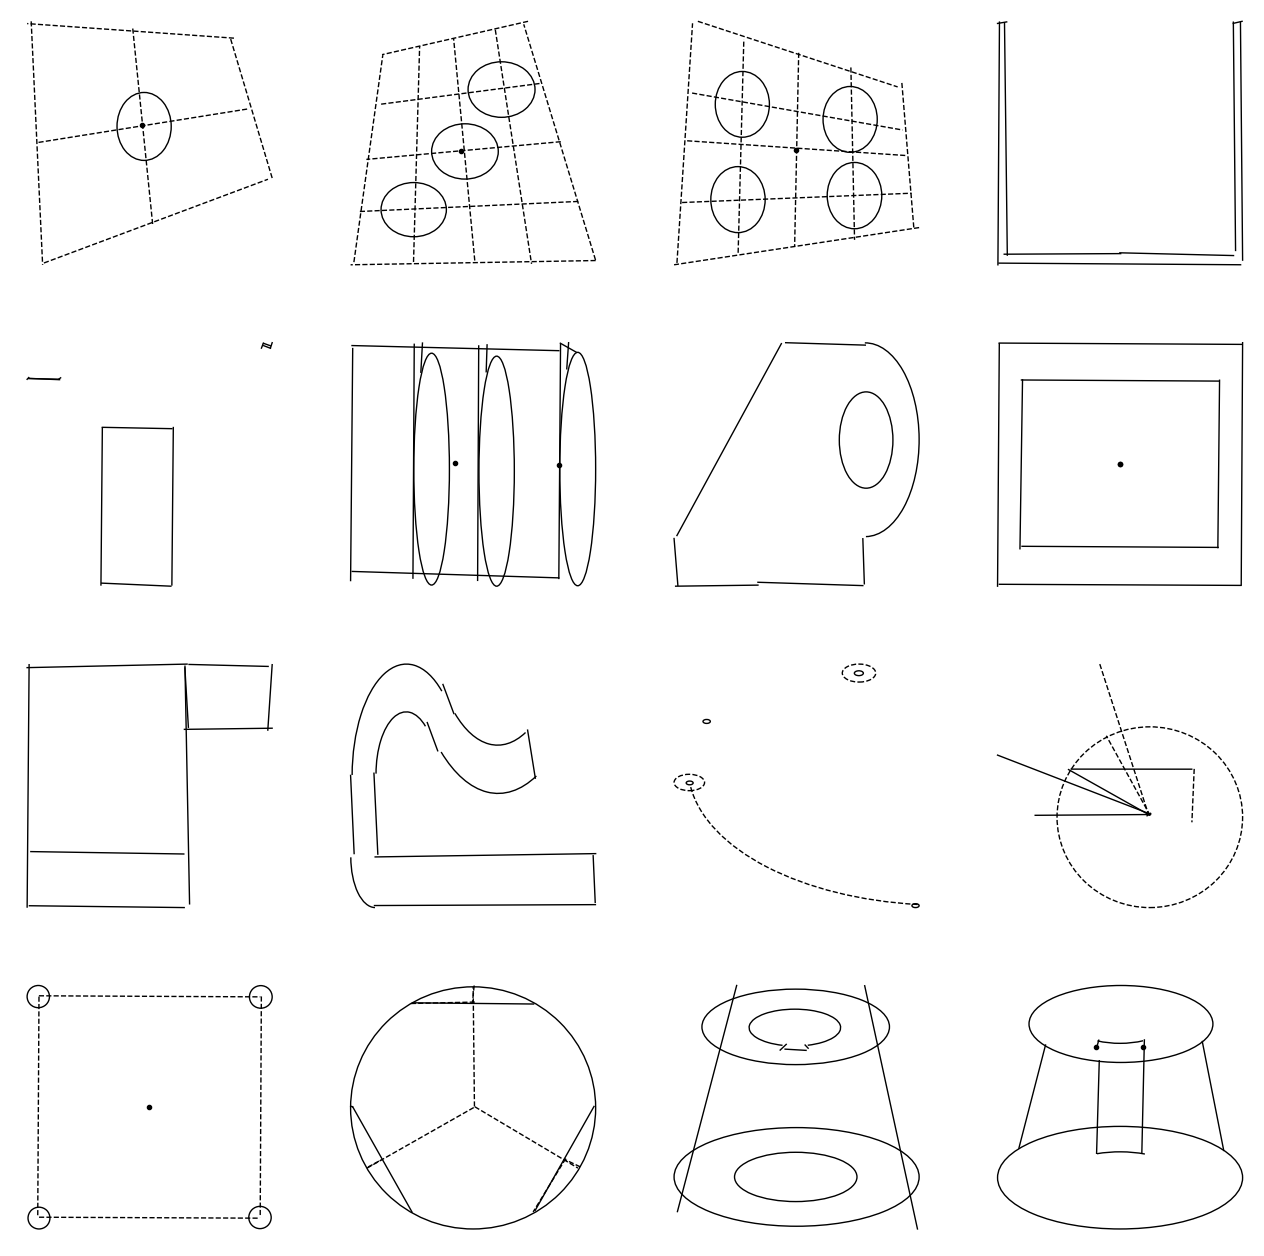

In [35]:
sharpener.eval()
with torch.no_grad():
    fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize=(16, 16))

    for graph_idx in range(16):
        noised_nodes, noised_edges, means, logvars = model(nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0))
        noised_nodes[...,0] = torch.sigmoid(noised_nodes[...,0])
        noised_nodes[...,1:6] = torch.softmax(noised_nodes[...,1:6], dim = -1)

        noised_edges[...,0:4] = torch.softmax(noised_edges[...,0:4], dim = -1)
        noised_edges[...,4:8] = torch.softmax(noised_edges[...,4:8], dim = -1)
        noised_edges[...,8:] = torch.softmax(noised_edges[...,8:], dim = -1)

        pred_nodes, pred_edges = sharpener(noised_nodes, noised_edges)

        # fig.suptitle(f"True - Pred - Noised")

        # SketchDataset.render_graph(nodes[graph_idx].cpu(), edges[graph_idx].cpu(), axes[0])
        col = graph_idx % 4
        row = graph_idx // 4
        SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[row, col])
        # SketchDataset.render_graph(noised_nodes.cpu().squeeze(0), noised_edges.cpu().squeeze(0), axes[2])

In [25]:
# model.eval()

# with torch.no_grad():
#     # graph_idx = 1
#     time = 1000
#     b = 5
#     sampled_nodes = torch.randn(b, 24, 20).to(gpu_id)
#     sampled_edges = torch.randn(b, 24, 24, 17).to(gpu_id)
#     # sampled_nodes = sqrt_a_bar[time,None,None] * nodes[graph_idx].unsqueeze(0) + sqrt_b_bar[time,None,None] * node_noise
#     # sampled_edges = sqrt_a_bar[time,None,None,None] * edges[graph_idx].unsqueeze(0) + sqrt_b_bar[time,None,None,None] * edge_noise

#     node_seed = sampled_nodes.clone()
#     edge_seed = sampled_edges.clone()

#     # SketchDataset.render_graph(sampled_nodes[0].cpu().squeeze(0), sampled_edges[0].cpu().squeeze(0), axes[0])

#     for i in reversed(range(1,time)):
#         pred_node_noise, pred_edge_noise = model(sampled_nodes, sampled_edges, torch.tensor([i]).to(gpu_id).expand(b))
        
#         denoised_node_mean = (sampled_nodes - pred_node_noise * (1 - a[i]) / sqrt_b_bar[i]) / sqrt_a[i]
#         denoised_edge_mean = (sampled_edges - pred_edge_noise * (1 - a[i]) / sqrt_b_bar[i]) / sqrt_a[i]

#         assert denoised_node_mean.isfinite().all()
#         assert denoised_edge_mean.isfinite().all()

#         if i > 1:
#             node_noise = torch.randn_like(sampled_nodes).to(gpu_id)
#             edge_noise = torch.randn_like(sampled_edges).to(gpu_id)

#             sampled_nodes = denoised_node_mean + (1 - a[i]).sqrt() * node_noise
#             sampled_edges = denoised_edge_mean + (1 - a[i]).sqrt() * edge_noise
#         else:
#             sampled_nodes = denoised_node_mean
#             sampled_edges = denoised_edge_mean

#             del denoised_node_mean
#             del denoised_edge_mean

#     assert sampled_nodes.isfinite().all()
#     assert sampled_edges.isfinite().all()

#     fig, axes = plt.subplots(nrows = b, ncols = 2, figsize=(4, b * 2))
#     fig.suptitle(f"Seed - Denoised")
#     for i in range(b):
#         SketchDataset.render_graph(node_seed[i].cpu().squeeze(0), edge_seed[i].cpu().squeeze(0), axes[i,0])
#         SketchDataset.render_graph(sampled_nodes[i].cpu().squeeze(0), sampled_edges[i].cpu().squeeze(0), axes[i,1])

In [26]:
# j = 0

# fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
# fig.suptitle(f"Seed - Denoised")

# SketchDataset.render_graph(node_seed[j].cpu().squeeze(0), edge_seed[j].cpu().squeeze(0), axes[0])
# SketchDataset.render_graph(sampled_nodes[j].cpu().squeeze(0), sampled_edges[j].cpu().squeeze(0), axes[1])

### Validate Loop

In [27]:
# def reverse_step(curr_nodes : Tensor, curr_edges : Tensor, pred_true_node : Tensor, pred_true_edge : Tensor, timestep : int, noise_scheduler : CosineNoiseScheduler):
#     new_nodes = torch.zeros_like(curr_nodes)
#     new_edges = torch.zeros_like(curr_edges)
#     pred_nodes = torch.zeros_like(curr_nodes)
#     pred_edges = torch.zeros_like(curr_edges)
#     # IsConstructible denoising
#     new_nodes[:,:,0], pred_nodes[:,:,0] = noise_scheduler.apply_bernoulli_posterior_step(curr_nodes[:,:,[0]], F.sigmoid(pred_true_node[:,:,[0]]), timestep)
#     # Primitive Types denoising
#     new_nodes[:,:,1:6], pred_nodes[:,:,1:6] = noise_scheduler.apply_multinomial_posterior_step(curr_nodes[:,:,1:6], F.softmax(pred_true_node[:,:,1:6], -1), timestep)
#     # Primitive parameters denoising
#     new_nodes[:,:,6:], pred_nodes[:,:,6:] = noise_scheduler.apply_gaussian_posterior_step(curr_nodes[:,:,6:], pred_true_node[:,:,6:], timestep)
#     # Subnode A denoising
#     new_edges[:,:,:,0:4], pred_edges[:,:,:,0:4] = noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,0:4], F.softmax(pred_true_edge[:,:,:,0:4], -1), timestep)
#     # Subnode B denoising
#     new_edges[:,:,:,4:8], pred_edges[:,:,:,4:8] = noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,4:8], F.softmax(pred_true_edge[:,:,:,4:8], -1), timestep)
#     # Constraint Types denoising
#     new_edges[:,:,:,8:], pred_edges[:,:,:,8:] = noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,8:], F.softmax(pred_true_edge[:,:,:,8:], -1), timestep)
#     return new_nodes, new_edges, pred_nodes, pred_edges

In [28]:
# model.eval()
# noise_scheduler = CosineNoiseScheduler3(4000, gpu_id)
# graph_idx = 2
# stepsize = 10
# frames = 3000 // stepsize
# fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16, 4))
# fig.suptitle("True - Noised - Pred - Next")

# def animation_fun(frame : int, curr_nodes : Tensor, curr_edges : Tensor, axes):
#     timestep = frames * stepsize - frame * stepsize + 1

#     for i in range(stepsize):
#         pred_nodes_noise, pred_edges_noise = model(curr_nodes, curr_edges, torch.Tensor([timestep - i]).int())
#         # assert pred_node_noise.isfinite().all() and pred_edge_noise.isfinite().all()

#         # Reverse Step
#         new_nodes, new_edges, pred_nodes, pred_edges = model.reverse_step(curr_nodes, pred_nodes_noise, curr_edges, pred_edges_noise, int(timestep - i))
#         # curr_nodes, curr_edges = model.reverse_step(curr_nodes, curr_edges, nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), timestep)

#         curr_nodes[...] = new_nodes
#         curr_edges[...] = new_edges
        
#     for ax in axes:
#         ax.cla()
        
#     SketchDataset.render_graph(nodes[graph_idx].cpu().squeeze(0), edges[graph_idx].cpu().squeeze(0), axes[0])
#     SketchDataset.render_graph(curr_nodes.cpu().squeeze(0), curr_edges.cpu().squeeze(0), axes[1])
#     SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[2])
#     SketchDataset.render_graph(new_nodes.cpu().squeeze(0), new_edges.cpu().squeeze(0), axes[3])

# curr_nodes, curr_edges, _, _ = noise_scheduler(nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), frames * stepsize)
# animation = FuncAnimation(fig = fig, func = partial(animation_fun, curr_nodes = curr_nodes, curr_edges = curr_edges, axes = axes), frames = frames, interval = 200, repeat_delay = 1000)

# video = animation.to_html5_video()
# display.display(display.HTML(video))
# plt.close()


In [29]:
# curr_nodes, _ = noise_scheduler(nodes[graph_idx].unsqueeze(0), 250)
# print("")

In [30]:
# model.eval()
# fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16, 4))
# graph_idx = 2
# t = 150
# temp_t = torch.tensor([t]).to(gpu_id)

# noised_nodes, noised_edges, node_noise, edge_noise = model.noise_scheduler(nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), t)
# pred_node_noise, pred_edge_noise = model(noised_nodes, noised_edges, temp_t)
# new_nodes, new_edges, pred_nodes, pred_edges = model.reverse_step(noised_nodes, noised_edges, pred_node_noise, pred_edge_noise, t)

# SketchDataset.render_graph(nodes[graph_idx].cpu().squeeze(0), edges[graph_idx].cpu().squeeze(0), axes[0])
# SketchDataset.render_graph(noised_nodes.cpu().squeeze(0), noised_edges.cpu().squeeze(0), axes[1])
# SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[2])
# SketchDataset.render_graph(new_nodes.cpu().squeeze(0), new_edges.cpu().squeeze(0), axes[3])

In [31]:
# torch.save(model.state_dict(), "gaussdiff_32tflayer_model.pth")

In [32]:
# noise_scheduler = CosineNoiseScheduler2(500, 1)
# d = 4
# gpu_id = 1
# precisions = 1.0 - torch.linspace(start = 0.0, end = 1.0, steps = 500) ** 0.5
# precisions = precisions[1:] / precisions[:-1]
# precisions.to(gpu_id)

# cumulative_precisions = precisions.cumprod(0)

In [33]:
# for t in range(1, 500):
#     x0 = torch.tensor([0.0, 0.0, 1.0, 0.0], device = gpu_id)
#     x = x0.unsqueeze(0).expand(10000, -1)
#     m = torch.tensor([0.25, 0.25, 0.25, 0.25], device = gpu_id)

#     for i in range(1, t):
#         p = precisions[i] # noise_scheduler.precisions[i]
#         v = 1.0 - p
#         s = (1 - precisions[i]).sqrt() # (noise_scheduler.precisions[i - 1] * (1 - noise_scheduler.precisions[i])).sqrt() # (float(i)/250.0 - 1.0) ** 3 / 2 + 0.5  # (float(i) / 500.0)
#         x = torch.softmax(((p * x + v * m).log() + s * noise_scheduler.gumbel_dist.sample(x.shape).squeeze(-1).to(gpu_id)), dim = -1)

#     true_dist = F.one_hot(torch.argmax(x, dim = -1), d).float().mean(dim = 0)
#     p_bar = cumulative_precisions[t]
#     v_bar = 1.0 - p_bar
#     s = 0.7 * ((1 - precisions[:t])).sum().sqrt() # (float(t) / 500.0) ** 2
#     appr_dist = torch.softmax((x0 * p_bar + m * v_bar).log() / s, dim = -1)
#     print(true_dist, " & ", appr_dist)

In [4]:
from collections import OrderedDict

def DDP_to_normal(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # Remove 'module.'
        new_state_dict[name] = v

    return new_state_dict

def freeze_model(model):
    model = model.eval()
    for p in model.parameters():
        p.requires_grad = False

In [5]:
gpu_id = 0

sampler = Sampler(gpu_id)
vae = GVAE(gpu_id)
sharpener = Sharpener(gpu_id)

# model.load_state_dict(torch.load("model_checkpoint_gaussdiff_ddp_Adam_32tflayers.pth"))
# Load the original saved file with DataParallel
sampler_state_dict = torch.load('model_checkpoint_sampler_ddp_Adam_depth_32_1.pth')
vae_state_dict = torch.load('checkpoints/model_checkpoint_gvae_ddp_Adam_mse-25_kld-.001_16layers16heads256hiddenencoder_16layers16heads256hiddendecoder_embedim1024_tempnodedim128_relu_after_node_layernorm.pth')
sharpener_state_dict = torch.load('model_checkpoint_sharpener_ddp_Adam_16tflayers.pth')


# Load the parameters into your model and freeze
sampler.load_state_dict(DDP_to_normal(sampler_state_dict))
vae.load_state_dict(DDP_to_normal(vae_state_dict))
sharpener.load_state_dict(DDP_to_normal(sharpener_state_dict))

freeze_model(sampler)
freeze_model(vae)
freeze_model(sharpener)


In [7]:
T = sampler.max_timestep
a_bar = torch.cos(0.5 * torch.pi * (torch.arange(0.0, 1.0, 1/(T + 1)) + .008) / 1.008) ** 2
a_bar = a_bar / a_bar[0]
a_bar = a_bar.to(gpu_id)

a = a_bar[1:] / a_bar[:-1]
a = torch.cat([a, torch.tensor([0.0]).to(gpu_id)])

sqrt_a = a.sqrt()
sqrt_a_bar = a_bar.sqrt().to(gpu_id)
sqrt_b_bar = (1 - a_bar).sqrt().to(gpu_id)

sqrt_post_var = torch.cat([torch.tensor([0.0]).to(gpu_id), (a_bar[:-1] / a_bar[1:] * (1 - a[1:]))]).sqrt()

def sample_latent(batch_size):
    sampled_latents = torch.randn((batch_size, 1024)).to(gpu_id)

    for i in reversed(range(1, sampler.max_timestep)):
        pred_latents = sampler(sampled_latents, torch.full(size = (batch_size,), fill_value = i).to(gpu_id))
      
        denoised_mean = (sqrt_a_bar[i - 1] * (1 - a[i]) * pred_latents + sqrt_a[i] * (1 - a_bar[i - 1]) * sampled_latents) / (1 - a_bar[i])
        if i > 1:
            sampled_latents = denoised_mean + sqrt_post_var[i] * torch.randn_like(denoised_mean)
        else:
            sampled_latents = denoised_mean
    
    return sampled_latents
      

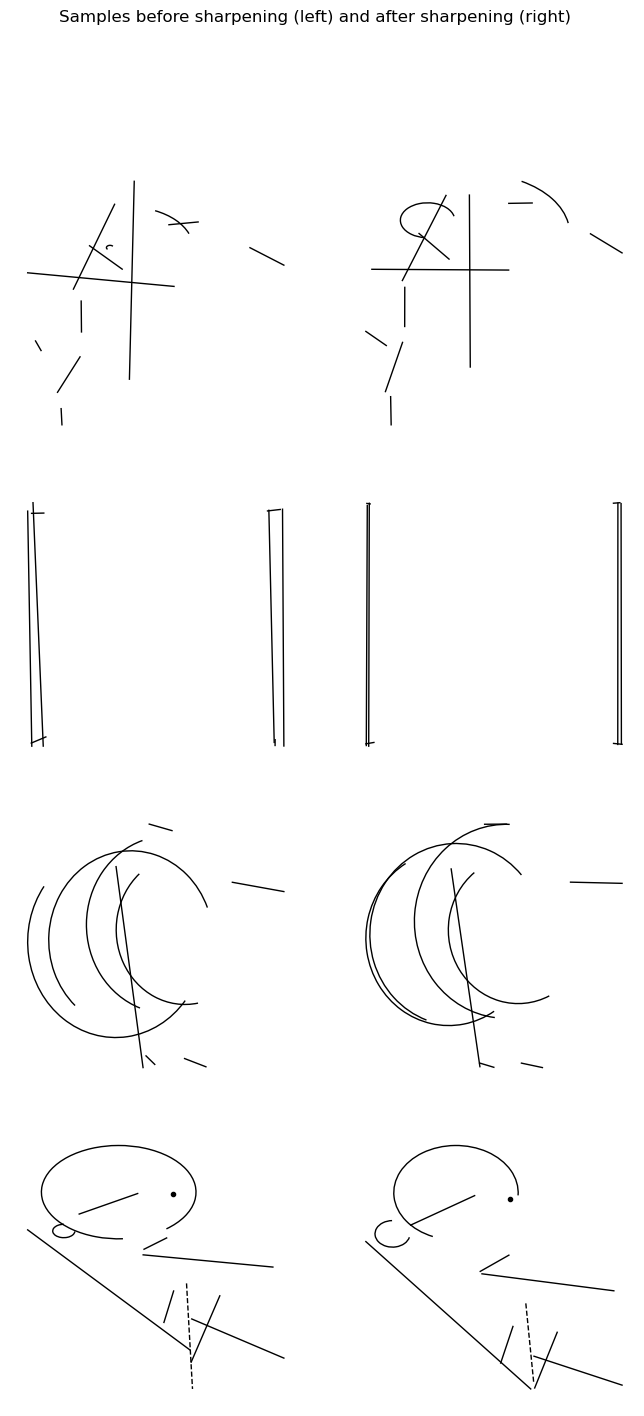

In [34]:
with torch.no_grad():
    latents = sample_latent(4)
    noisy_nodes, noisy_edges = vae.decoder(latents)

    nodes = noisy_nodes.clone()
    edges = noisy_edges.clone()

    for _ in range(2):
        nodes, edges = sharpener(nodes, edges)

        # Normalize probs
        nodes[...,0] = torch.sigmoid(nodes[...,0])
        nodes[...,1:6] = torch.softmax(nodes[...,1:6], dim = -1)

        edges[...,0:4] = torch.softmax(edges[...,0:4], dim = -1)
        edges[...,4:8] = torch.softmax(edges[...,4:8], dim = -1)
        edges[...,8: ] = torch.softmax(edges[...,8: ], dim = -1)

    fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(8, 16))
    fig.suptitle("Samples before sharpening (left) and after sharpening (right)", fontsize = 12)
    for i in range(4):
        SketchDataset.render_graph(noisy_nodes[i].cpu(), noisy_edges[i].cpu(), axes[i, 0])
        SketchDataset.render_graph(nodes[i].cpu(), edges[i].cpu(), axes[i, 1])

In [41]:
embedding_dataset = torch.load("embedding_dataset.pth")
dataset = SketchDataset(root="data/")

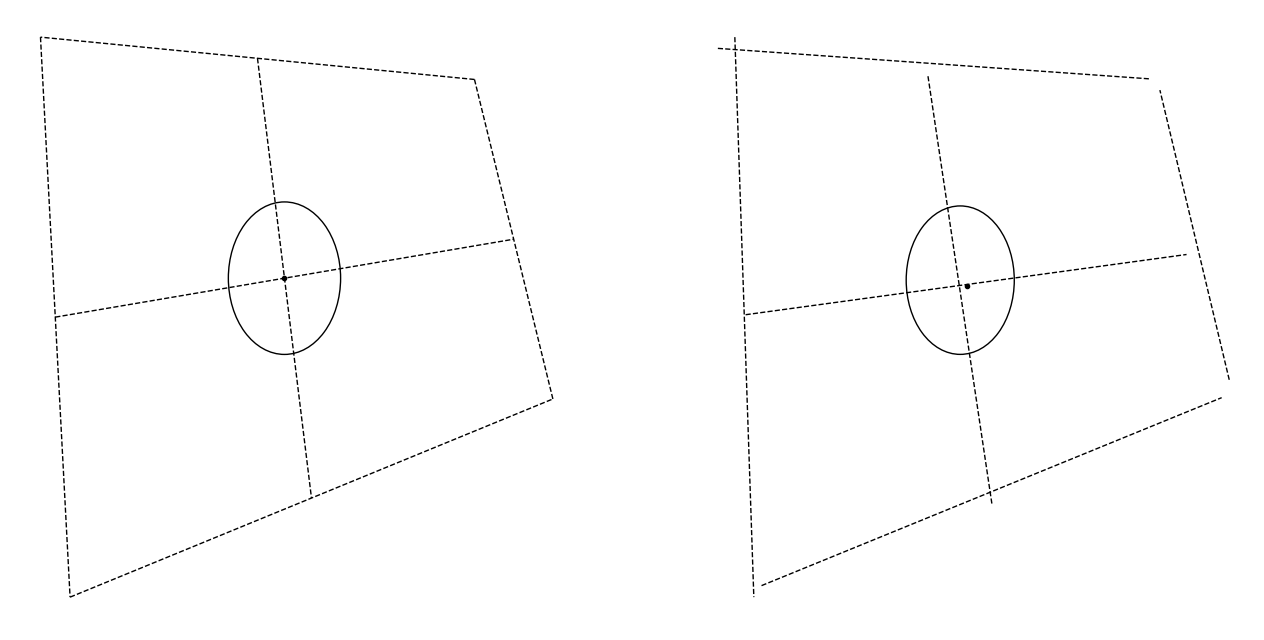

In [47]:
graph_id = 0
mean = embedding_dataset[0][graph_id].unsqueeze(0).to(gpu_id)

nodes, edges = vae.decoder(mean)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
SketchDataset.render_graph(dataset.nodes[graph_id], dataset.edges[graph_id], axes[0])
SketchDataset.render_graph(nodes[0], edges[0], axes[1])